<a href="https://colab.research.google.com/github/Soumabha4444/MLBA_Project_57C/blob/main/Stock_Forecasting_Multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# create folders exactly as in the repo
!mkdir -p mlba-stock-forecasting/{src,data/raw,data/processed,outputs,results}
%cd mlba-stock-forecasting


/content/mlba-stock-forecasting


In [ ]:
!pip install yfinance numpy pandas scikit-learn torch tqdm scipy matplotlib seaborn joblib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%writefile src/data.py
import argparse
from datetime import datetime
import pandas as pd
import yfinance as yf
import os

def download_price(ticker, start, end, out_csv):
    df = yf.download(ticker, start=start, end=end, progress=False)
    df = df.reset_index().rename(columns={'Date':'date'})
    df['ticker'] = ticker
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    df.to_csv(out_csv, index=False)
    print(f"Saved prices to {out_csv}")
    return df

if __name__ == "__main__":
    download_price("AAPL", "2008-01-01", "2016-10-31", "data/raw/aapl.csv")

# This downloads real AAPL stock data and saves it as data/raw/aapl.csv

Writing src/data.py


In [ ]:
%%writefile src/features.py
import argparse
import os
import pandas as pd
import numpy as np

def create_features(df, lags=(1,2,3,5,10,20), roll_mean_win=5, roll_std_win=20):
    # normalize date column
    if 'Date' in df.columns and 'date' not in df.columns:
        df = df.rename(columns={'Date':'date'})
    if 'date' not in df.columns:
        raise ValueError("Input dataframe must contain a 'date' or 'Date' column.")
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # standardize some common column names (map spaces -> underscores)
    to_check = ['Open','High','Low','Close','Adj Close','Adj_Close','Volume']
    for col in to_check:
        if col in df.columns:
            std_name = col.replace(' ', '_')
            df[std_name] = pd.to_numeric(df[col], errors='coerce')

    # prefer adjusted close if Close missing
    if 'Close' not in df.columns and 'Adj_Close' in df.columns:
        df['Close'] = df['Adj_Close']

    # accept lowercase variant
    if 'close' in df.columns and 'Close' not in df.columns:
        df['Close'] = pd.to_numeric(df['close'], errors='coerce')

    # sort and drop rows missing Close
    df = df.sort_values('date').copy().reset_index(drop=True)
    df = df.dropna(subset=['Close']).reset_index(drop=True)

    # create price-based target: next-day close (kept for reference)
    df['close_next'] = df['Close'].shift(-1)

    # next-day log return target (preferred for modeling)
    # ret_next = log(close_next / Close)
    df['ret_next'] = np.log(df['close_next'] / df['Close'])

    # log return (today)
    df['ret'] = np.log(df['Close']).diff()

    # lag features
    for l in lags:
        df[f'ret_lag_{l}'] = df['ret'].shift(l)

    # rolling stats
    df[f'ret_roll_{roll_mean_win}_mean'] = df['ret'].rolling(roll_mean_win).mean()
    df[f'ret_roll_{roll_std_win}_std'] = df['ret'].rolling(roll_std_win).std()

    # list of columns required for modelling
    cols_needed = ['ret_next'] + [f'ret_lag_{l}' for l in lags] + [f'ret_roll_{roll_mean_win}_mean', f'ret_roll_{roll_std_win}_std']

    df = df.dropna(subset=cols_needed).reset_index(drop=True)

    if df.empty:
        raise ValueError("No rows remain after feature creation. Check input data length and column names.")

    return df

def save_sample(df, out_csv, n=200):
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    df.head(n).to_csv(out_csv, index=False)
    print("Saved sample slice to", out_csv)

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--input", dest="infile", required=False, default="data/raw/aapl.csv",
                        help="Input raw CSV file (has Date/Close/Adj Close etc.)")
    parser.add_argument("--out", dest="outfile", required=False, default="data/processed/aapl_features.parquet")
    parser.add_argument("--sample_out", dest="sample_out", default="data/sample_slice.csv")
    parser.add_argument("--sample_n", type=int, default=200)
    args = parser.parse_args()

    if not os.path.exists(args.infile):
        raise SystemExit(f"Input file not found: {args.infile}")
    df = pd.read_csv(args.infile)
    df_feats = create_features(df)
    os.makedirs(os.path.dirname(args.outfile), exist_ok=True)
    df_feats.to_parquet(args.outfile, index=False)
    save_sample(df_feats, args.sample_out, n=args.sample_n)
    print(f"Saved features to {args.outfile} with {len(df_feats)} rows")

if __name__ == "__main__":
    main()


Writing src/features.py


In [ ]:
%%writefile src/train_baseline.py
import argparse, os, json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from scipy import stats

def rmse(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    return float(math.sqrt(np.mean((y_true - y_pred) ** 2)))

def directional_accuracy_returns(y_true, y_pred):
    """
    Directional accuracy for returns: sign(pred) == sign(true)
    Returns percentage in [0,100].
    """
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    n = min(len(y_true), len(y_pred))
    if n == 0:
        return 0.0
    signs_pred = np.sign(y_pred[:n])
    signs_true = np.sign(y_true[:n])
    acc = np.mean(signs_pred == signs_true)
    return float(100.0 * acc)

def rolling_origin(df, initial_train_days=800, test_days=60, step_days=60):
    dates = sorted(df['date'].unique())
    folds=[]
    start_idx=0
    while True:
        train_end = start_idx + initial_train_days - 1
        test_start = train_end + 1
        test_end = test_start + test_days - 1
        if test_end >= len(dates): break
        folds.append((dates[0], dates[train_end], dates[test_start], dates[test_end]))
        start_idx += step_days
    return folds

def run_fold(df, train_end_date, test_start, test_end, features):
    train_df = df[df['date']<=train_end_date]
    test_df = df[(df['date']>=test_start) & (df['date']<=test_end)].copy().reset_index(drop=True)

    X_train = train_df[features].values
    y_train = train_df['ret_next'].values   # now predicting next-day log return
    X_test = test_df[features].values
    y_test = test_df['ret_next'].values

    # Keep current_close for reference (not used for DA on returns)
    current_close = test_df['Close'].values if 'Close' in test_df.columns else np.full_like(y_test, np.nan, dtype=float)

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # compute metrics for this fold (on returns)
    mae_val = float(mean_absolute_error(y_test, preds))
    rmse_val = float(rmse(y_test, preds))
    da_val = directional_accuracy_returns(y_test, preds)

    # convert arrays to plain python lists (floats / None) for JSON
    def as_pylist(arr, cast=float):
        out = []
        for x in list(arr):
            if pd.isna(x) or (isinstance(x, float) and (np.isinf(x) or np.isnan(x))):
                out.append(None)
            else:
                out.append(cast(x))
        return out

    return {
        "y_true": as_pylist(y_test, float),
        "y_pred": as_pylist(preds, float),
        "current_close": as_pylist(current_close, float),
        "metrics": {
            "MAE": mae_val,
            "RMSE": rmse_val,
            "DA_percent": da_val
        }
    }

def t_ci(x, alpha=0.95):
    x = np.array(x, dtype=float); n=len(x)
    if n == 0:
        return 0.0, 0.0, 0.0
    mean = float(np.mean(x))
    if n == 1:
        return mean, mean, mean
    se = float(np.std(x, ddof=1)/math.sqrt(n))
    t = stats.t.ppf((1+alpha)/2., n-1)
    return mean, mean - t*se, mean + t*se

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--features", required=False, default="data/processed/aapl_features.parquet")
    parser.add_argument("--out", required=False, default="outputs/baseline_preds.json")
    args = parser.parse_args()

    df = pd.read_parquet(args.features)
    df = df.sort_values('date').reset_index(drop=True)

    # pick feature columns (lags & rolling stats)
    features = [c for c in df.columns if c.startswith('ret_lag_') or c.startswith('ret_roll_')]

    folds = rolling_origin(df)
    os.makedirs(os.path.dirname(args.out), exist_ok=True)
    all_preds=[]

    for idx,(train_start, train_end, test_start, test_end) in enumerate(folds):
        print(f"Fold {idx}: train_end={train_end}, test_start={test_start}, test_end={test_end}")
        rec = run_fold(df, train_end, test_start, test_end, features)
        # stringify timestamps
        def to_str(d):
            try:
                return d.isoformat()
            except Exception:
                return str(d)
        out_rec = {
            "fold": int(idx),
            "model": "ridge_baseline",
            "train_start": to_str(train_start),
            "train_end": to_str(train_end),
            "test_start": to_str(test_start),
            "test_end": to_str(test_end),
            "y_true": rec["y_true"],
            "y_pred": rec["y_pred"],
            "current_close": rec["current_close"],
            "metrics": rec["metrics"]
        }
        all_preds.append(out_rec)

    # compute summary across folds
    maes = [r["metrics"]["MAE"] for r in all_preds]
    rmses = [r["metrics"]["RMSE"] for r in all_preds]
    das = [r["metrics"]["DA_percent"] for r in all_preds]

    summary = {
        "MAE": { "mean": t_ci(maes)[0], "lo": t_ci(maes)[1], "hi": t_ci(maes)[2] },
        "RMSE": { "mean": t_ci(rmses)[0], "lo": t_ci(rmses)[1], "hi": t_ci(rmses)[2] },
        "DA_percent": { "mean": t_ci(das)[0], "lo": t_ci(das)[1], "hi": t_ci(das)[2] }
    }

    out_blob = {
        "per_fold": all_preds,
        "summary": summary
    }

    with open(args.out,"w") as f:
        json.dump(out_blob,f, indent=2)
    print("Saved preds and metrics to", args.out)

if __name__=="__main__":
    main()


Writing src/train_baseline.py


In [ ]:
%%writefile src/eval.py
import json, argparse, os, math, sys
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats

def t_confidence_interval(x, confidence=0.95):
    x = np.array(x, dtype=float)
    n = len(x)
    if n == 0:
        return 0.0, 0.0, 0.0
    mean = float(np.mean(x))
    if n == 1:
        return mean, mean, mean
    se = float(np.std(x, ddof=1) / math.sqrt(n))
    t = stats.t.ppf((1 + confidence) / 2.0, n - 1)
    return mean, mean - t * se, mean + t * se

def directional_accuracy_filtered(y_true, y_pred):
    """
    Compute directional accuracy (%) for returns.
    Filters out non-finite entries and aligns arrays.
    """
    # convert to numpy arrays and attempt to coerce to float
    y_t = np.array([_safe_float(x) for x in y_true], dtype=float)
    y_p = np.array([_safe_float(x) for x in y_pred], dtype=float)

    # mask finite entries in both
    mask = np.isfinite(y_t) & np.isfinite(y_p)
    if mask.sum() == 0:
        return 0.0
    y_t = y_t[mask]
    y_p = y_p[mask]
    signs_true = np.sign(y_t)
    signs_pred = np.sign(y_p)
    acc = np.mean(signs_true == signs_pred)
    return float(100.0 * acc)

def _safe_float(x):
    try:
        v = float(x)
        if math.isfinite(v):
            return v
    except Exception:
        pass
    return float('nan')

def load_preds(path):
    blob = json.load(open(path))
    if isinstance(blob, dict) and "per_fold" in blob:
        records = blob["per_fold"]
    elif isinstance(blob, list):
        records = blob
    else:
        raise ValueError("Unrecognized preds_json structure. Expect list or dict with 'per_fold'.")
    return records

def t_confidence_interval_list(x):
    return t_confidence_interval(x)

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--preds_json", required=True)
    parser.add_argument("--out", required=True)
    args = parser.parse_args()

    records = load_preds(args.preds_json)

    maes, rmses, das = [], [], []
    for rec in records:
        y_true = rec.get("y_true", [])
        y_pred = rec.get("y_pred", [])
        # compute per-fold metrics, making sure to coerce/filter invalid entries
        # MAE/RMSE: only use aligned finite pairs
        y_t = np.array([_safe_float(x) for x in y_true], dtype=float)
        y_p = np.array([_safe_float(x) for x in y_pred], dtype=float)
        mask = np.isfinite(y_t) & np.isfinite(y_p)
        if mask.sum() == 0:
            continue
        y_t_f = y_t[mask]
        y_p_f = y_p[mask]
        maes.append(float(mean_absolute_error(y_t_f, y_p_f)))
        rmses.append(float(math.sqrt(mean_squared_error(y_t_f, y_p_f))))
        das.append(directional_accuracy_filtered(y_t_f, y_p_f))

    mae_mean, mae_lo, mae_hi = t_confidence_interval_list(maes)
    rmse_mean, rmse_lo, rmse_hi = t_confidence_interval_list(rmses)
    da_mean, da_lo, da_hi = t_confidence_interval_list(das)

    out = {
        "MAE_mean": mae_mean, "MAE_lo": mae_lo, "MAE_hi": mae_hi,
        "RMSE_mean": rmse_mean, "RMSE_lo": rmse_lo, "RMSE_hi": rmse_hi,
        "DA_mean": da_mean, "DA_lo": da_lo, "DA_hi": da_hi
    }

    os.makedirs(os.path.dirname(args.out), exist_ok=True)
    with open(args.out, "w") as f:
        json.dump(out, f, indent=2)
    print("Saved metrics to", args.out)
    print(json.dumps(out, indent=2))

if __name__ == "__main__":
    main()


Writing src/eval.py


In [ ]:
!python src/data.py
# inspect downloaded CSV without parse_dates
import pandas as pd
df = pd.read_csv("data/raw/aapl.csv")
print("COLUMNS:", df.columns.tolist())
print("\nFIRST 6 ROWS:")
display(df.head(6))
print("\nDTYPES:\n", df.dtypes)

/content/mlba-stock-forecasting/src/data.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, progress=False)
Saved prices to data/raw/aapl.csv
COLUMNS: ['date', 'Close', 'High', 'Low', 'Open', 'Volume', 'ticker']

FIRST 6 ROWS:


,date,Close,High,Low,Open,Volume,ticker
0,NaN,AAPL,AAPL,AAPL,AAPL,AAPL,NaN
1,2008-01-02,5.849119186401367,6.0118287377815385,5.780373950029967,5.9821089434096,1079178800,AAPL
2,2008-01-03,5.85181999206543,5.925669548226654,5.784575011135818,5.866229974388948,842066400,AAPL
3,2008-01-04,5.405121803283691,5.793882389595054,5.370298873762459,5.747351346743581,1455832000,AAPL
4,2008-01-07,5.332773208618164,5.51169317331155,5.1103238843778405,5.441145493849881,2072193200,AAPL
5,2008-01-08,5.140944004058838,5.477469947151359,5.127435045283893,5.4078224949057185,1523816000,AAPL



DTYPES:
 date      object
Close     object
High      object
Low       object
Open      object
Volume    object
ticker    object
dtype: object


In [ ]:
!pip install pyarrow


In [ ]:
!python src/features.py

Saved sample slice to data/sample_slice.csv
Saved features to data/processed/aapl_features.parquet with 2202 rows


In [ ]:
!python src/train_baseline.py

Fold 0: train_end=2011-04-04 00:00:00, test_start=2011-04-05 00:00:00, test_end=2011-06-29 00:00:00
Fold 1: train_end=2011-06-29 00:00:00, test_start=2011-06-30 00:00:00, test_end=2011-09-23 00:00:00
Fold 2: train_end=2011-09-23 00:00:00, test_start=2011-09-26 00:00:00, test_end=2011-12-19 00:00:00
Fold 3: train_end=2011-12-19 00:00:00, test_start=2011-12-20 00:00:00, test_end=2012-03-16 00:00:00
Fold 4: train_end=2012-03-16 00:00:00, test_start=2012-03-19 00:00:00, test_end=2012-06-12 00:00:00
Fold 5: train_end=2012-06-12 00:00:00, test_start=2012-06-13 00:00:00, test_end=2012-09-06 00:00:00
Fold 6: train_end=2012-09-06 00:00:00, test_start=2012-09-07 00:00:00, test_end=2012-12-04 00:00:00
Fold 7: train_end=2012-12-04 00:00:00, test_start=2012-12-05 00:00:00, test_end=2013-03-04 00:00:00
Fold 8: train_end=2013-03-04 00:00:00, test_start=2013-03-05 00:00:00, test_end=2013-05-29 00:00:00
Fold 9: train_end=2013-05-29 00:00:00, test_start=2013-05-30 00:00:00, test_end=2013-08-22 00:00:00


In [ ]:
!python src/eval.py --preds_json outputs/baseline_preds.json --out outputs/baseline_metrics.json


Saved metrics to outputs/baseline_metrics.json
{
  "MAE_mean": 0.012199034394008003,
  "MAE_lo": 0.011022186807270566,
  "MAE_hi": 0.013375881980745439,
  "RMSE_mean": 0.016519844699163334,
  "RMSE_lo": 0.014884440957546752,
  "RMSE_hi": 0.018155248440779915,
  "DA_mean": 50.362318840579704,
  "DA_lo": 46.81180730245322,
  "DA_hi": 53.91283037870619
}


In [ ]:
%%bash
python - <<'PY'
import pandas as pd, numpy as np, json, math
from scipy import stats
from sklearn.metrics import mean_absolute_error

# load processed features and preds
df = pd.read_parquet("data/processed/aapl_features.parquet")
blob = json.load(open("outputs/baseline_preds.json"))

# support both formats: list OR {"per_fold": [...], "summary": {...}}
if isinstance(blob, dict) and "per_fold" in blob:
    all_preds = blob["per_fold"]
else:
    all_preds = blob

# helper: compute RMSE
def rmse(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

# reconstruct folds used in train_baseline.py (same rolling_origin logic)
dates = sorted(df['date'].unique())
initial_train_days=800; test_days=60; step_days=60
folds=[]
start_idx=0
while True:
    train_end = start_idx + initial_train_days - 1
    test_start = train_end + 1
    test_end = test_start + test_days - 1
    if test_end >= len(dates): break
    folds.append((dates[0], dates[train_end], dates[test_start], dates[test_end]))
    start_idx += step_days

naive_maes=[]; naive_rmses=[]; naive_das=[]
ridge_maes=[]; ridge_rmses=[]; ridge_das=[]
# load ridge per-fold results (make sure fold keys are ints)
ridge_by_fold = {}
for rec in all_preds:
    fold_key = rec.get('fold')
    if fold_key is None:
        continue
    ridge_by_fold[int(fold_key)] = rec

for i,(train_start, train_end, test_start, test_end) in enumerate(folds):
    test_mask = (df['date']>=test_start)&(df['date']<=test_end)
    test_df = df[test_mask].copy().reset_index(drop=True)
    # find global indices in original df
    global_idx = df.index[(df['date']>=test_start) & (df['date']<=test_end)].tolist()

    # Handle cases where global_idx might be too early for a previous day's close
    # The 'ret_next' column is available, so this price-scale path is likely not taken.
    # However, for robustness, ensuring prev_close is handled correctly.
    if global_idx and min(global_idx) > 0:
      prev_idx_for_close_comparison = [idx-1 for idx in global_idx]
      prev_close_for_comparison = df.loc[prev_idx_for_close_comparison, 'Close'].values
    else:
      prev_close_for_comparison = np.array([])

    # Decide whether we are working in returns or price scale
    if 'ret_next' in df.columns:
        # return-scale naive: predict previous day's return (ret_lag_1) if present else zero
        y_true = df.loc[global_idx, 'ret_next'].values
        if 'ret_lag_1' in df.columns:
            naive_pred = df.loc[global_idx, 'ret_lag_1'].values
            if len(naive_pred) != len(y_true):
                naive_pred = naive_pred[:len(y_true)]
        else:
            naive_pred = np.zeros_like(y_true)

        # Ensure y_true and naive_pred are not empty before computing metrics
        if len(y_true) > 0 and len(naive_pred) > 0:
            naive_maes.append(float(mean_absolute_error(y_true, naive_pred)))
            naive_rmses.append(rmse(y_true, naive_pred))
            da_naive = np.mean(np.sign(naive_pred) == np.sign(y_true))
            naive_das.append(float(100.0 * da_naive))
        else:
            naive_maes.append(0.0)
            naive_rmses.append(0.0)
            naive_das.append(0.0)
    else:
        # This block is likely dead code since 'ret_next' is expected
        # price-scale naive: previous day's Close predicts next-day close
        y_true = df.loc[global_idx, 'close_next'].values
        naive_pred = prev_close_for_comparison # Assuming prev_close_for_comparison here is Close_t for close_next_t+1
        # Ensure y_true and naive_pred have the same length for MAE/RMSE
        min_len = min(len(y_true), len(naive_pred))
        if min_len == 0:
            naive_maes.append(0.0)
            naive_rmses.append(0.0)
            naive_das.append(0.0)
        else:
            naive_maes.append(float(mean_absolute_error(y_true[:min_len], naive_pred[:min_len])))
            naive_rmses.append(rmse(y_true[:min_len], naive_pred[:min_len]))
            # For directional accuracy, compare (y_true - prev_close) with (naive_pred - prev_close)
            if len(prev_close_for_comparison) >= min_len:
                da_naive = np.mean(np.sign(naive_pred[:min_len] - prev_close_for_comparison[:min_len]) == np.sign(y_true[:min_len] - prev_close_for_comparison[:min_len]))
            else:
                da_naive = 0.0 # Not enough data for comparison
            naive_das.append(float(100.0 * da_naive))

    # ridge per-fold
    ridge_rec = ridge_by_fold.get(i)
    if ridge_rec is None:
        # fold missing in preds JSON
        continue

    ridge_y = np.array(ridge_rec.get('y_true', []))
    ridge_p = np.array(ridge_rec.get('y_pred', []))
    # filter finite and align
    mask = np.isfinite(ridge_y) & np.isfinite(ridge_p)
    ridge_y = ridge_y[mask]; ridge_p = ridge_p[mask]
    if len(ridge_y) == 0:
        continue

    ridge_maes.append(float(mean_absolute_error(ridge_y, ridge_p)))
    ridge_rmses.append(rmse(ridge_y, ridge_p))

    # Directional accuracy for Ridge model (always on returns as per train_baseline.py)
    da_ridge = np.mean(np.sign(ridge_p) == np.sign(ridge_y))
    ridge_das.append(float(100.0 * da_ridge))

def t_ci(x,alpha=0.95):
    x = np.array(x); n=len(x)
    mean = float(np.mean(x)) if n>0 else 0.0
    se = float(np.std(x, ddof=1)/math.sqrt(n)) if n>1 else 0.0
    t = stats.t.ppf((1+alpha)/2., n-1) if n>1 else 0.0
    return mean, mean - t*se, mean + t*se

out = {
 "seasonal_naive": {
   "MAE_mean": t_ci(naive_maes)[0], "MAE_lo": t_ci(naive_maes)[1], "MAE_hi": t_ci(naive_maes)[2],
   "RMSE_mean": t_ci(naive_rmses)[0], "RMSE_lo": t_ci(naive_rmses)[1], "RMSE_hi": t_ci(naive_rmses)[2],
   "DA_mean": t_ci(naive_das)[0], "DA_lo": t_ci(naive_das)[1], "DA_hi": t_ci(naive_das)[2]
 },
 "ridge_baseline": {
   "MAE_mean": t_ci(ridge_maes)[0], "MAE_lo": t_ci(ridge_maes)[1], "MAE_hi": t_ci(ridge_maes)[2],
   "RMSE_mean": t_ci(ridge_rmses)[0], "RMSE_lo": t_ci(ridge_rmses)[1], "RMSE_hi": t_ci(ridge_rmses)[2],
   "DA_mean": t_ci(ridge_das)[0], "DA_lo": t_ci(ridge_das)[1], "DA_hi": t_ci(ridge_das)[2]
 }
}

# Directly print the 'out' dictionary as pretty-formatted JSON
print(json.dumps(out, indent=2))
PY

{
  "seasonal_naive": {
    "MAE_mean": 0.017733695857360576,
    "MAE_lo": 0.015843833773274793,
    "MAE_hi": 0.019623557941446358,
    "RMSE_mean": 0.023151427251859143,
    "RMSE_lo": 0.02059742925307313,
    "RMSE_hi": 0.025705425250645158,
    "DA_mean": 49.71014492753623,
    "DA_lo": 46.96441334605667,
    "DA_hi": 52.45587650901578
  },
  "ridge_baseline": {
    "MAE_mean": 0.012199034394008003,
    "MAE_lo": 0.011022186807270566,
    "MAE_hi": 0.013375881980745439,
    "RMSE_mean": 0.016519844699163334,
    "RMSE_lo": 0.014884440957546752,
    "RMSE_hi": 0.018155248440779915,
    "DA_mean": 50.362318840579704,
    "DA_lo": 46.81180730245322,
    "DA_hi": 53.91283037870619
  }
}


In [ ]:
%%writefile src/train_lstm.py
#!/usr/bin/env python3
# save as src/train_lstm.py
import argparse, os, json, math
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from scipy import stats
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ---------------------------
# PyTorch LSTM model
# ---------------------------
class SeqDataset(Dataset):
    def __init__(self, X, y):
        # X: (#samples, seq_len, n_features), y: (#samples,)
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (B, T, F)
        out, _ = self.lstm(x)           # out: (B, T, hidden)
        out = out[:, -1, :]             # take last timestep
        out = self.fc(out)              # (B,1)
        return out.squeeze(1)          # (B,)

# ---------------------------
# Utilities
# ---------------------------
def rmse(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def t_ci(x, alpha=0.95):
    x = np.array(x, dtype=float); n=len(x)
    if n == 0:
        return 0.0, 0.0, 0.0
    mean = float(np.mean(x))
    if n == 1:
        return mean, mean, mean
    se = float(np.std(x, ddof=1)/math.sqrt(n))
    t = stats.t.ppf((1+alpha)/2., n-1)
    return mean, mean - t*se, mean + t*se

def directional_accuracy_percent(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if mask.sum() == 0:
        return 0.0
    y_true = y_true[mask]; y_pred = y_pred[mask]
    return float(100.0 * np.mean(np.sign(y_true) == np.sign(y_pred)))

# ---------------------------
# Build sliding sequences
# ---------------------------
def build_sequences(df, features, seq_len):
    """
    Given sorted df, returns:
      indices: list of indices i for which sequence X[i] ends at row i (so target is at row i)
      X_seq: np.array (#samples, seq_len, n_features)
      y: np.array (#samples,) -> df.loc[i, 'ret_next']
    Only rows where full seq_len history exists are included.
    """
    n = len(df)
    X_list = []
    y_list = []
    idx_list = []
    arr = df[features].values
    targets = df['ret_next'].values
    for end_idx in range(seq_len - 1, n):
        start_idx = end_idx - (seq_len - 1)
        # ensure target exists and finite
        if not np.isfinite(targets[end_idx]):
            continue
        seq = arr[start_idx:end_idx+1]  # shape (seq_len, n_features)
        if np.any(~np.isfinite(seq)):
            continue
        X_list.append(seq)
        y_list.append(targets[end_idx])
        idx_list.append(end_idx)
    if len(X_list) == 0:
        return np.empty((0, seq_len, len(features))), np.empty((0,)), []
    return np.stack(X_list), np.array(y_list), idx_list

# ---------------------------
# Train per-fold LSTM
# ---------------------------
def train_epoch(model, loader, opt, loss_fn, device):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb = Xb.to(device); yb = yb.to(device)
        opt.zero_grad()
        out = model(Xb)
        loss = loss_fn(out, yb)
        loss.backward()
        opt.step()
        total_loss += float(loss.item()) * Xb.size(0)
    return total_loss / len(loader.dataset)

def predict(model, loader, device):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            out = model(Xb).cpu().numpy()
            preds.append(out)
            trues.append(yb.numpy())
    if len(preds) == 0:
        return np.array([]), np.array([])
    return np.concatenate(trues), np.concatenate(preds)

# ---------------------------
# Main: rolling folds
# ---------------------------
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--features", default="data/processed/aapl_features.parquet")
    parser.add_argument("--out", default="outputs/lstm_preds.json")
    parser.add_argument("--seq_len", type=int, default=10)
    parser.add_argument("--hidden", type=int, default=64)
    parser.add_argument("--epochs", type=int, default=20)
    parser.add_argument("--batch_size", type=int, default=64)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--device", default="cpu")
    args = parser.parse_args()

    df = pd.read_parquet(args.features).sort_values('date').reset_index(drop=True)
    # choose features to feed LSTM per-timestep
    features = [c for c in df.columns if c.startswith('ret_lag_') or c.startswith('ret_roll_') or c in ['ret']]
    if len(features) == 0:
        raise SystemExit("No features found for LSTM. Check your processed parquet columns.")

    # rolling-origin folds (same as baseline)
    dates = sorted(df['date'].unique())
    initial_train_days=800; test_days=60; step_days=60
    folds=[]
    start_idx=0
    while True:
        train_end = start_idx + initial_train_days - 1
        test_start = train_end + 1
        test_end = test_start + test_days - 1
        if test_end >= len(dates): break
        folds.append((dates[0], dates[train_end], dates[test_start], dates[test_end]))
        start_idx += step_days

    device = torch.device(args.device if torch.cuda.is_available() or args.device=='cpu' else 'cpu')
    out_recs = []

    for idx, (train_start, train_end, test_start, test_end) in enumerate(folds):
        print(f"[Fold {idx}] train_end={train_end}, test_start={test_start}, test_end={test_end}")
        # split df by date
        train_mask = df['date'] <= train_end
        test_mask = (df['date'] >= test_start) & (df['date'] <= test_end)
        df_train = df[train_mask].reset_index(drop=True)
        df_test = df[test_mask].reset_index(drop=True)

        # Build sequences from the full train portion to scale properly and then build for test using scaler
        X_train_seq, y_train_seq, idxs_train = build_sequences(df_train, features, args.seq_len)
        # for test sequences we need context that may include rows inside train - so build sequences on concatenated df up to test_end
        df_upto_test = df[df['date'] <= test_end].reset_index(drop=True)
        X_all_seq, y_all_seq, idxs_all = build_sequences(df_upto_test, features, args.seq_len)

        # identify which sequences correspond to test indices (those whose end idx is in df_upto_test and date between test_start/test_end)
        test_end_positions = []
        # map idxs_all (which are indices in df_upto_test) to dates; need to pick those with date in test range
        dates_all = df_upto_test['date'].values
        for pos, end_idx in enumerate(idxs_all):
            dt = dates_all[end_idx]
            if (dt >= np.datetime64(test_start)) and (dt <= np.datetime64(test_end)):
                test_end_positions.append(pos)

        # now prepare X_test_seq and y_test_seq
        if len(test_end_positions) == 0:
            print(f"  no test sequences for fold {idx}, skipping")
            continue
        X_test_seq = X_all_seq[test_end_positions]
        y_test_seq = y_all_seq[test_end_positions]

        # scale features: fit scaler on flattened training sequences (all timesteps)
        n_feats = len(features)
        if X_train_seq.shape[0] == 0:
            print("  no train sequences for this fold; skipping")
            continue
        # flatten to (num_samples * seq_len, n_feats)
        flat_train = X_train_seq.reshape(-1, n_feats)
        scaler = StandardScaler().fit(flat_train)
        # apply scaler
        X_train_seq_scaled = scaler.transform(flat_train).reshape(X_train_seq.shape)
        X_test_seq_scaled = scaler.transform(X_test_seq.reshape(-1, n_feats)).reshape(X_test_seq.shape)

        # build dataloaders
        train_ds = SeqDataset(X_train_seq_scaled, y_train_seq)
        test_ds = SeqDataset(X_test_seq_scaled, y_test_seq)
        train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False)

        # model
        model = LSTMRegressor(input_size=n_feats, hidden_size=args.hidden).to(device)
        loss_fn = nn.MSELoss()
        opt = torch.optim.Adam(model.parameters(), lr=args.lr)

        # training loop
        for ep in range(args.epochs):
            tr_loss = train_epoch(model, train_loader, opt, loss_fn, device)
            if (ep+1) % 5 == 0 or ep == 0 or ep == args.epochs-1:
                print(f"   Epoch {ep+1}/{args.epochs}, train_loss={tr_loss:.6f}")

        # predict on test
        y_true, y_pred = predict(model, test_loader, device)
        # convert to plain floats
        y_true_list = [float(x) for x in y_true.tolist()]
        y_pred_list = [float(x) for x in y_pred.tolist()]

        mae_val = float(mean_absolute_error(y_true, y_pred))
        rmse_val = rmse(y_true, y_pred)
        da_val = directional_accuracy_percent(y_true, y_pred)

        # record
        out_rec = {
            "fold": int(idx),
            "model": "lstm_numerical",
            "train_start": pd.to_datetime(str(train_start)).isoformat(),
            "train_end": pd.to_datetime(str(train_end)).isoformat(),
            "test_start": pd.to_datetime(str(test_start)).isoformat(),
            "test_end": pd.to_datetime(str(test_end)).isoformat(),
            "y_true": y_true_list,
            "y_pred": y_pred_list,
            "metrics": {
                "MAE": mae_val,
                "RMSE": rmse_val,
                "DA_percent": da_val
            }
        }
        out_recs.append(out_rec)

    # summary across folds
    maes = [r["metrics"]["MAE"] for r in out_recs]
    rmses = [r["metrics"]["RMSE"] for r in out_recs]
    das = [r["metrics"]["DA_percent"] for r in out_recs]
    summary = {
        "MAE": {"mean": t_ci(maes)[0], "lo": t_ci(maes)[1], "hi": t_ci(maes)[2]},
        "RMSE": {"mean": t_ci(rmses)[0], "lo": t_ci(rmses)[1], "hi": t_ci(rmses)[2]},
        "DA_percent": {"mean": t_ci(das)[0], "lo": t_ci(das)[1], "hi": t_ci(das)[2]}
    }

    os.makedirs(os.path.dirname(args.out), exist_ok=True)
    out_blob = {"per_fold": out_recs, "summary": summary}
    with open(args.out, "w") as f:
        json.dump(out_blob, f, indent=2)
    print("Saved LSTM preds+metrics to", args.out)

if __name__ == "__main__":
    main()

Writing src/train_lstm.py


In [ ]:
!python src/features.py --input data/raw/aapl.csv --out data/processed/aapl_features.parquet


Saved sample slice to data/sample_slice.csv
Saved features to data/processed/aapl_features.parquet with 2202 rows


In [ ]:
!python src/train_lstm.py --features data/processed/aapl_features.parquet --out outputs/lstm_preds.json --seq_len 10 --epochs 20 --hidden 64 --batch_size 64 --lr 1e-3 --device cpu


[Fold 0] train_end=2011-04-04 00:00:00, test_start=2011-04-05 00:00:00, test_end=2011-06-29 00:00:00
   Epoch 1/20, train_loss=0.002470
   Epoch 5/20, train_loss=0.000611
   Epoch 10/20, train_loss=0.000561
   Epoch 15/20, train_loss=0.000554
   Epoch 20/20, train_loss=0.000500
[Fold 1] train_end=2011-06-29 00:00:00, test_start=2011-06-30 00:00:00, test_end=2011-09-23 00:00:00
   Epoch 1/20, train_loss=0.002058
   Epoch 5/20, train_loss=0.000585
   Epoch 10/20, train_loss=0.000506
   Epoch 15/20, train_loss=0.000469
   Epoch 20/20, train_loss=0.000450
[Fold 2] train_end=2011-09-23 00:00:00, test_start=2011-09-26 00:00:00, test_end=2011-12-19 00:00:00
   Epoch 1/20, train_loss=0.003233
   Epoch 5/20, train_loss=0.000544
   Epoch 10/20, train_loss=0.000502
   Epoch 15/20, train_loss=0.000475
   Epoch 20/20, train_loss=0.000441
[Fold 3] train_end=2011-12-19 00:00:00, test_start=2011-12-20 00:00:00, test_end=2012-03-16 00:00:00
   Epoch 1/20, train_loss=0.001922
   Epoch 5/20, train_loss=0

In [ ]:
!python src/eval.py --preds_json outputs/lstm_preds.json --out outputs/lstm_metrics.json
!cat outputs/lstm_metrics.json


Saved metrics to outputs/lstm_metrics.json
{
  "MAE_mean": 0.012866363107648635,
  "MAE_lo": 0.011597102762979476,
  "MAE_hi": 0.014135623452317794,
  "RMSE_mean": 0.017185575751011716,
  "RMSE_lo": 0.015485040282239262,
  "RMSE_hi": 0.01888611121978417,
  "DA_mean": 50.14492753623189,
  "DA_lo": 46.44490355990235,
  "DA_hi": 53.84495151256143
}
{
  "MAE_mean": 0.012866363107648635,
  "MAE_lo": 0.011597102762979476,
  "MAE_hi": 0.014135623452317794,
  "RMSE_mean": 0.017185575751011716,
  "RMSE_lo": 0.015485040282239262,
  "RMSE_hi": 0.01888611121978417,
  "DA_mean": 50.14492753623189,
  "DA_lo": 46.44490355990235,
  "DA_hi": 53.84495151256143
}

In [ ]:
%%writefile src/build_text_embeddings.py
#!/usr/bin/env python3
"""
build_text_embeddings.py

Robust SBERT embedding builder for a news CSV.

Features:
 - Detects date column (configurable with --date_col). Falls back to common names.
 - If date column is an integer (epoch), converts to datetime (configurable unit).
 - Allows specifying text column name (--text_col).
 - Computes SBERT embeddings for entire dataset in batches.
 - Saves parquet with columns: date (datetime normalized to date), text_emb (list of floats), optionally other meta.
"""

import argparse
from pathlib import Path
from typing import Optional, List
import sys

import pandas as pd
import numpy as np
from tqdm import tqdm

# sentence-transformers
try:
    from sentence_transformers import SentenceTransformer
except Exception as e:
    print("ERROR: sentence_transformers not available. Install with `pip install sentence-transformers`.", file=sys.stderr)
    raise

COMMON_DATE_COLS = ["date", "created_utc", "timestamp", "created", "publish_date", "published_at", "time"]

def detect_date_col(df: pd.DataFrame, prefer: Optional[str] = None) -> Optional[str]:
    if prefer and prefer in df.columns:
        return prefer
    for c in COMMON_DATE_COLS:
        if c in df.columns:
            return c
    # otherwise try to find a datetime-like column
    for c in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[c]):
            return c
    # try numeric columns that look like epoch (very large ints)
    for c in df.columns:
        if pd.api.types.is_integer_dtype(df[c]) or pd.api.types.is_float_dtype(df[c]):
            series = df[c].dropna()
            if len(series) == 0:
                continue
            v = series.iloc[0]
            # heuristic: epoch seconds are > 1e9 (since 2001) and < 1e11
            if isinstance(v, (int, float)) and (1e9 < abs(v) < 1e12):
                return c
    return None

def parse_dates_column(series: pd.Series, unit: str = "s") -> pd.Series:
    # If already datetime, return normalized datetimes
    if pd.api.types.is_datetime64_any_dtype(series):
        return pd.to_datetime(series).dt.normalize()
    # If numeric, treat as epoch
    if pd.api.types.is_integer_dtype(series) or pd.api.types.is_float_dtype(series):
        # use pandas to_datetime with unit
        return pd.to_datetime(series, unit=unit, errors="coerce").dt.normalize()
    # otherwise try parsing strings
    return pd.to_datetime(series, errors="coerce").dt.normalize()

def main():
    p = argparse.ArgumentParser()
    p.add_argument("--news_csv", required=True, help="Input CSV of news (must contain text column)")
    p.add_argument("--out", required=True, help="Output parquet path (will include columns 'date','text_emb')")
    p.add_argument("--text_col", default=None, help="Column name containing the text (title/body). If not set, tries common choices.")
    p.add_argument("--date_col", default=None, help="Column name containing date/timestamp. If not set, auto-detects.")
    p.add_argument("--epoch_unit", choices=["s", "ms"], default="s", help="If date column is numeric epoch, unit (seconds 's' or milliseconds 'ms').")
    p.add_argument("--model_name", default="sentence-transformers/all-MiniLM-L6-v2", help="SBERT model name")
    p.add_argument("--batch_size", type=int, default=128)
    p.add_argument("--device", default="cpu")
    p.add_argument("--text_cols_try", nargs="*", default=["title", "headline", "body", "content", "text"], help="Text columns to try if --text_col not provided")
    args = p.parse_args()

    path = Path(args.news_csv)
    if not path.exists():
        raise FileNotFoundError(f"{path} does not exist")

    # Read a small sample first to inspect columns
    sample = pd.read_csv(path, nrows=10)
    print("CSV columns:", sample.columns.tolist())

    # decide text column
    text_col = args.text_col
    if text_col is None:
        for c in args.text_cols_try:
            if c in sample.columns:
                text_col = c
                break
    if text_col is None:
        # fallback: choose first object dtype column that's not the detected date_col
        for c in sample.columns:
            if sample[c].dtype == object:
                text_col = c
                break
    if text_col is None:
        raise ValueError("Could not infer text column. Provide --text_col explicitly.")
    print("Using text column:", text_col)

    # read full CSV (we'll not parse dates yet)
    df = pd.read_csv(path)
    print("Read full CSV shape:", df.shape)

    # detect date column
    date_col = args.date_col or detect_date_col(df)
    if date_col is None:
        print("No date column detected; resulting parquet will have NaT for 'date'. You can pass --date_col to specify.")
        df["date_parsed"] = pd.NaT
    else:
        print("Using date column:", date_col)
        df["date_parsed"] = parse_dates_column(df[date_col], unit=args.epoch_unit)

    # normalize to midnight (date-only)
    df["date_parsed"] = pd.to_datetime(df["date_parsed"], errors="coerce").dt.normalize()

    # build a simple text series (concatenate title+body if both exist)
    # If text_col points to a combined field, use it
    text_series = df[text_col].astype(str).fillna("").values
    # If there's a 'body' column and text_col is only title, try to combine
    if "body" in df.columns and text_col != "body":
        # prefer title + body if available
        text_series = (df[text_col].fillna("").astype(str) + ". " + df["body"].fillna("").astype(str)).values

    # initialize SBERT model
    print("Loading SBERT model:", args.model_name)
    model = SentenceTransformer(args.model_name, device=args.device)

    # compute embeddings in batches
    n = len(text_series)
    batch_size = max(1, args.batch_size)
    embeddings: List[np.ndarray] = []
    print(f"Computing embeddings for {n} rows with batch_size={batch_size} on device={args.device}")
    for i in tqdm(range(0, n, batch_size)):
        batch_texts = text_series[i : i + batch_size].tolist()
        emb = model.encode(batch_texts, show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=False)
        embeddings.append(emb)
    embeddings = np.vstack(embeddings)  # shape (n, emb_dim)
    print("Embeddings shape:", embeddings.shape)

    # attach embeddings (as python lists) to dataframe
    df_out = pd.DataFrame(
        {
            "date": pd.to_datetime(df["date_parsed"]).dt.normalize(),
            "text_emb": [e.tolist() for e in embeddings],
        }
    )

    # if you want to keep other metadata (e.g., title, url), add them:
    # df_out["title"] = df.get("title", pd.Series([""]*len(df)))
    # df_out["url"] = df.get("url", pd.Series([""]*len(df)))

    out_path = Path(args.out)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df_out.to_parquet(out_path, index=False)
    print("Wrote embeddings to", out_path)

if __name__ == "__main__":
    main()


Writing src/build_text_embeddings.py


In [ ]:
pip install transformers torch tqdm pandas pyarrow


In [ ]:
%%bash
python src/build_text_embeddings.py \
  --news_csv data/raw/RedditNews.csv \
  --out data/processed/text_embeddings.parquet \
  --batch_size 128 \
  --device cpu \
  --text_col News \
  --date_col Date \
  --epoch_unit s

CSV columns: ['Date', 'News']
Using text column: News
Read full CSV shape: (73608, 2)
Using date column: Date
Loading SBERT model: sentence-transformers/all-MiniLM-L6-v2
Computing embeddings for 73608 rows with batch_size=128 on device=cpu
Embeddings shape: (73608, 384)
Wrote embeddings to data/processed/text_embeddings.parquet


2025-11-09 09:43:26.053493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762681406.109795   10159 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762681406.127977   10159 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762681406.179382   10159 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762681406.179461   10159 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762681406.179465   10159 computation_placer.cc:177] computation placer alr

In [ ]:
%%bash
python - <<'PY'
import pandas as pd, numpy as np, json, os
pd.options.display.width = 160

emb_path = "data/processed/text_embeddings.parquet"
feat_path = "data/processed/aapl_features.parquet"

def show(msg): print("\n=== " + msg + " ===")

# 1) File existence
show("Files present")
print("embeddings exists:", os.path.exists(emb_path))
print("features exists:", os.path.exists(feat_path))

if not os.path.exists(emb_path):
    raise SystemExit("text_embeddings.parquet not found. Run build_text_embeddings.py first.")
if not os.path.exists(feat_path):
    raise SystemExit("aapl_features.parquet not found. Run features.py first.")

# 2) Load small samples
show("Load embedding file (head)")
df_emb = pd.read_parquet(emb_path)
print("rows (dates) in embeddings:", len(df_emb))
print("columns:", list(df_emb.columns))
print(df_emb.head(5).to_dict('records')[:5])

# 3) Embedding shape & dtype checks
show("Embedding shape & dtype checks")
# ensure text_emb column exists
if 'text_emb' not in df_emb.columns:
    print("ERROR: no 'text_emb' column found.")
else:
    # check element types and length distribution
    lens = df_emb['text_emb'].apply(lambda x: len(x) if isinstance(x,(list,tuple,np.ndarray)) else -1)
    print("embedding vector lengths (unique counts):")
    print(lens.value_counts().to_dict())
    # sample one vector numeric stats
    sample_idx = lens.idxmax()
    vec = df_emb.loc[sample_idx,'text_emb']
    if isinstance(vec,(list,tuple,np.ndarray)):
        arr = np.array(vec, dtype=float)
        print("sample vector dtype:", arr.dtype, "shape:", arr.shape)
        print("sample vector stats: mean {:.6f}, std {:.6f}, min {:.6f}, max {:.6f}".format(arr.mean(), arr.std(), arr.min(), arr.max()))
    else:
        print("sample vector is not list-like:", type(vec))

# 4) NaN / null checks
show("Null / NaN checks")
null_text_emb = df_emb['text_emb'].isna().sum()
print("text_emb null count:", null_text_emb)
# if text_emb present but some entries not lists
bad_entries = df_emb['text_emb'].apply(lambda x: not isinstance(x,(list,tuple,np.ndarray)))
print("non-list text_emb entries:", int(bad_entries.sum()))

# 5) Date coverage vs features
show("Date coverage alignment with aapl_features")
df_feat = pd.read_parquet(feat_path)
df_feat['date'] = pd.to_datetime(df_feat['date']).dt.normalize()
df_emb['date'] = pd.to_datetime(df_emb['date']).dt.normalize()
dates_feat = set(df_feat['date'].unique())
dates_emb = set(df_emb['date'].unique())
common = sorted(list(dates_feat & dates_emb))
print("unique stock dates:", len(dates_feat))
print("unique embedding dates:", len(dates_emb))
print("overlap dates:", len(common), "({:.1%})".format(len(common)/len(dates_feat)))
print("first 5 matched dates:", common[:5])
print("first 5 stock-only dates (example):", list(sorted(dates_feat - dates_emb))[:5])
print("first 5 emb-only dates (example):", list(sorted(dates_emb - dates_feat))[:5])

# 6) Quick sanity: check if embeddings were averaged (i.e., not identical across days)
show("Sanity: variety across embeddings")
if len(df_emb) >= 2:
    # compute pairwise distance sample
    n = min(200, len(df_emb))
    sample = df_emb['text_emb'].apply(lambda x: np.array(x,dtype=float)).values[:n]
    means = [v.mean() for v in sample]
    print("sample mean of vectors (first 10):", [float(m) for m in means[:10]])
    # compute std of means
    print("std of vector means across sample:", float(np.std(means)))
else:
    print("Not enough embedding dates to check variety.")

# 7) If everything looks OK, print one example of embeddings merged with features for a date
show("Sample merged row (if overlap exists)")
if len(common) > 0:
    d = common[0]
    emb_row = df_emb[df_emb['date']==d].iloc[0]
    feat_row = df_feat[df_feat['date']==d].iloc[0]
    print("date:", d)
    print("feature columns sample:", {c: float(feat_row[c]) for c in ['ret'] if 'ret' in feat_row})
    print("embedding sample (first 8 dims):", np.array(emb_row['text_emb'],dtype=float)[:8].tolist())
else:
    print("No overlapping dates to display merged example.")

print("\\nDone.")
PY



=== Files present ===
embeddings exists: True
features exists: True

=== Load embedding file (head) ===
rows (dates) in embeddings: 73608
columns: ['date', 'text_emb']
[{'date': Timestamp('2016-07-01 00:00:00'), 'text_emb': array([-3.27281952e-02,  6.92857727e-02, -7.82452598e-02,  8.92044380e-02,
        6.16298765e-02,  1.90350413e-02, -8.91246349e-02,  6.94398955e-03,
       -3.76664028e-02,  2.63277236e-02,  6.53022453e-02, -3.22593227e-02,
        3.60599421e-02, -1.94225721e-02, -5.39694056e-02,  3.59263346e-02,
       -1.24027148e-01, -1.39124002e-02, -1.76910777e-03,  2.78770085e-02,
       -3.53500955e-02,  1.74325816e-02,  2.61090859e-03,  3.05023380e-02,
        1.50437346e-02, -3.11678220e-02, -3.13687325e-02, -4.34636995e-02,
        3.49768177e-02, -3.33533529e-03,  1.76618006e-02,  5.56184128e-02,
       -6.74656481e-02, -1.82258561e-02, -1.83785427e-02,  8.04618653e-03,
        7.20669329e-02,  6.66547045e-02,  1.88012384e-02, -4.78569837e-03,
       -1.39132980e-02, -

In [ ]:
# code for early fusion

%%writefile src/train_multimodal_lstm.py
#!/usr/bin/env python3
"""
train_multimodal_lstm.py

Updated version with:
 - robust embedding alignment + aggregation
 - overlap statistics printing
 - emb_fill modes: zero, ffill, hybrid (ffill up to N then zero)
 - robust target detection / computation
 - fixed shape handling for sequences (no incorrect reshape)
 - debug prints
"""

import argparse
from pathlib import Path
import json
from typing import Tuple, Optional, List

import numpy as np
import pandas as pd
from tqdm import tqdm

# PyTorch (if not needed, you can change to any other framework)
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# -----------------------
# Helpers
# -----------------------
COMMON_TARGET_NAMES = ["target", "y", "ret", "returns", "target_return", "next_return"]
COMMON_DATE_COLS = ["date", "created_utc", "timestamp", "created", "publish_date", "published_at", "time"]


def detect_date_col(df: pd.DataFrame, prefer: Optional[str] = None) -> Optional[str]:
    if prefer and prefer in df.columns:
        return prefer
    for c in COMMON_DATE_COLS:
        if c in df.columns:
            return c
    for c in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[c]):
            return c
    for c in df.columns:
        if pd.api.types.is_integer_dtype(df[c]) or pd.api.types.is_float_dtype(df[c]):
            series = df[c].dropna()
            if len(series) == 0:
                continue
            v = series.iloc[0]
            if isinstance(v, (int, float)) and (1e9 < abs(v) < 1e12):
                return c
    return None


def parse_dates_column(series: pd.Series, unit: str = "s") -> pd.Series:
    if pd.api.types.is_datetime64_any_dtype(series):
        return pd.to_datetime(series).dt.normalize()
    if pd.api.types.is_integer_dtype(series) or pd.api.types.is_float_dtype(series):
        return pd.to_datetime(series, unit=unit, errors="coerce").dt.normalize()
    return pd.to_datetime(series, errors="coerce").dt.normalize()


def align_embeddings_to_trade_dates(
    df_num: pd.DataFrame,
    df_text: pd.DataFrame,
    emb_agg: str = "mean",
    emb_fill: str = "zero",
    emb_ffill_limit: int = 0,
    debug: bool = False,
) -> Tuple[pd.DataFrame, int]:
    """
    Align text embeddings to the dates present in df_num (trading dates).
    Returns (df_out, emb_dim) where df_out has columns ['date','text_emb'] (text_emb is list of floats).
    emb_fill: 'zero' | 'ffill' | 'hybrid' (hybrid == ffill up to emb_ffill_limit then zeros)
    emb_agg: aggregation over multiple text items per date: mean|sum|max
    """
    df_num = df_num.copy()
    df_num["date"] = pd.to_datetime(df_num["date"]).dt.normalize()
    df_text = df_text.copy()
    if "date" in df_text.columns:
        df_text["date"] = pd.to_datetime(df_text["date"]).dt.normalize()
    else:
        # ensure there's at least a date column (maybe named differently)
        date_col = detect_date_col(df_text)
        if date_col:
            df_text["date"] = pd.to_datetime(df_text[date_col]).dt.normalize()
        else:
            df_text["date"] = pd.NaT

    if "text_emb" not in df_text.columns:
        raise ValueError("text embeddings dataframe must contain 'text_emb' column")

    # Convert list/array to numpy arrays and drop invalids
    def to_arr(x):
        try:
            if isinstance(x, (list, tuple, np.ndarray)):
                arr = np.asarray(x, dtype=float)
                return arr
            # sometimes stored as string representation
            if isinstance(x, str):
                # try to eval safely: fallback - not ideal but often necessary
                import ast

                v = ast.literal_eval(x)
                arr = np.asarray(v, dtype=float)
                return arr
        except Exception:
            return None
        return None

    df_text["_emb_arr"] = df_text["text_emb"].apply(to_arr)
    df_text = df_text[~df_text["_emb_arr"].isna()].copy()
    if df_text.shape[0] == 0:
        raise ValueError("No valid embeddings found in text embeddings dataframe (column 'text_emb')")

    emb_dim = df_text["_emb_arr"].iloc[0].shape[0]
    # keep only rows with matching embedding dim
    df_text = df_text[df_text["_emb_arr"].apply(lambda x: x.shape[0] == emb_dim)].copy()

    # Build DataFrame with one column per embedding dimension indexed by date
    emb_cols = [f"emb_{i}" for i in range(emb_dim)]
    emb_df = pd.DataFrame(df_text["_emb_arr"].tolist(), columns=emb_cols, index=df_text["date"])
    emb_df.index.name = "date"

    # aggregate multiple items per date
    if emb_agg == "mean":
        emb_daily = emb_df.groupby(emb_df.index).mean()
    elif emb_agg == "sum":
        emb_daily = emb_df.groupby(emb_df.index).sum()
    elif emb_agg == "max":
        emb_daily = emb_df.groupby(emb_df.index).max()
    else:
        emb_daily = emb_df.groupby(emb_df.index).mean()

    # alignment index (we align to stock feature dates)
    stock_dates = pd.to_datetime(df_num["date"].unique()).normalize()
    emb_index = pd.DatetimeIndex(sorted(stock_dates))
    emb_daily = emb_daily.reindex(emb_index)  # missing dates -> NaNs

    # Overlap stats
    unique_stock_dates = len(stock_dates)
    unique_emb_dates = emb_daily.dropna(how="all").shape[0]
    overlap = len(set(stock_dates).intersection(set(emb_daily.dropna(how="all").index)))
    if debug:
        print("=== Embedding/Feature date overlap statistics ===")
        print("Unique stock feature dates:", unique_stock_dates)
        print("Unique embedding dates:", unique_emb_dates)
        print(f"Overlap (stock ∩ emb): {overlap} ({overlap/unique_stock_dates*100:.2f}% of stock dates)")
        stock_dt_sorted = sorted(stock_dates)
        emb_dt_sorted = sorted(emb_daily.dropna(how="all").index)
        print("Example overlap dates (first 10):", list(sorted(set(stock_dt_sorted).intersection(set(emb_dt_sorted))))[:10])
        print("Example stock-only dates (first 10):", stock_dt_sorted[:10])
        print("Example emb-only dates (first 10):", emb_dt_sorted[:10])
        print("emb_fill:", emb_fill, "emb_ffill_limit:", emb_ffill_limit)
        print("===============================================")

    # Apply filling strategy
    if emb_fill == "zero":
        emb_filled = emb_daily.fillna(0.0)
    elif emb_fill == "ffill":
        emb_filled = emb_daily.ffill(limit=emb_ffill_limit)
    elif emb_fill in ("hybrid", "ffill_then_zero"):
        emb_filled = emb_daily.ffill(limit=emb_ffill_limit).fillna(0.0)
    else:
        emb_filled = emb_daily.fillna(0.0)

    # Convert back to list column in the same order as df_num's dates
    df_dates_order = pd.DataFrame({"date": pd.to_datetime(df_num["date"]).dt.normalize()})
    # Use emb_filled rows by df_dates_order order (for index alignment)
    # If some dates are outside emb index, reindex will produce NaNs -> fill as per above logic
    emb_for_dates = emb_filled.reindex(df_dates_order["date"].values).fillna(0.0)
    emb_list = emb_for_dates.values.tolist()
    df_out = df_dates_order.copy()
    df_out["text_emb"] = emb_list
    return df_out, emb_dim


def detect_or_compute_target(df: pd.DataFrame, target_col_arg: Optional[str], debug: bool = False) -> Tuple[pd.DataFrame, str]:
    """
    Ensure df has a 'target' column. If none present and price column exists, compute next-day pct change.
    Returns (df, target_col_name)
    """
    df = df.copy()
    if target_col_arg and target_col_arg in df.columns:
        if debug:
            print(f"Using provided target column: {target_col_arg}")
        return df, target_col_arg

    for c in COMMON_TARGET_NAMES:
        if c in df.columns:
            if debug:
                print(f"Found existing target column: {c}")
            return df, c

    # try to compute from price columns
    price_col = None
    if "adj_close" in df.columns:
        price_col = "adj_close"
    elif "close" in df.columns:
        price_col = "close"
    elif "Close" in df.columns:
        price_col = "Close"

    if price_col:
        if debug:
            print(f"Computing target as next-day pct change of price col '{price_col}'")
        df = df.sort_values("date").copy()
        df["target"] = df[price_col].pct_change().shift(-1)  # next-day return
        return df, "target"

    raise ValueError("No 'target' column found in features parquet. Provide --target_col or include a price column like 'close' or 'adj_close' to compute one.")


# -----------------------
# Simple LSTM model
# -----------------------
class SimpleLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 1, dropout: float = 0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.head = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, (hn, cn) = self.lstm(x)  # out: (batch, seq_len, hidden_size)
        # use last timestep
        last = out[:, -1, :]
        y = self.head(last)
        return y.squeeze(-1)


# -----------------------
# Sequence creation
# -----------------------
def create_sequences(features_df: pd.DataFrame, seq_len: int, feature_cols: List[str], target_col: str) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """
    Build sequences from a dataframe sorted by date.
    Returns (X, y, df_sorted) where:
     - X shape = (n_samples, seq_len, n_features)
     - y shape = (n_samples,)
    """
    df = features_df.sort_values("date").reset_index(drop=True).copy()
    vals = df[feature_cols].values.astype(float)
    targets = df[target_col].values.astype(float)

    n = len(df)
    seqs = []
    ys = []
    indices = []
    for i in range(n - seq_len):
        seq = vals[i : i + seq_len]
        tgt = targets[i + seq_len]  # predict next day's target
        if np.isnan(tgt):
            continue
        seqs.append(seq)
        ys.append(tgt)
        indices.append(i)
    if len(seqs) == 0:
        return np.zeros((0, seq_len, len(feature_cols))), np.zeros((0,)), df
    X = np.stack(seqs, axis=0)
    y = np.array(ys, dtype=float)
    return X, y, df


# -----------------------
# Main
# -----------------------
def main():
    p = argparse.ArgumentParser()
    p.add_argument("--features", required=True, help="Features parquet with 'date' and feature columns")
    p.add_argument("--text_emb", required=True, help="Text embeddings parquet with 'date' and 'text_emb' (list) columns")
    p.add_argument("--seq_len", type=int, default=10)
    p.add_argument("--emb_agg", default="mean", choices=["mean", "sum", "max"])
    p.add_argument("--emb_fill", default="zero", choices=["zero", "ffill", "hybrid"])
    p.add_argument("--emb_ffill_limit", type=int, default=0, help="Days to forward-fill embeddings for ffill/hybrid")
    p.add_argument("--target_col", default=None, help="Name of target column if present")
    p.add_argument("--epochs", type=int, default=10)
    p.add_argument("--batch_size", type=int, default=64)
    p.add_argument("--lr", type=float, default=1e-3)
    p.add_argument("--device", default="cpu", help="cpu or cuda")
    p.add_argument("--out", default="outputs/multimodal_lstm_preds.json")
    p.add_argument("--debug", action="store_true")
    p.add_argument("--flatten_for_classical", action="store_true", help="If set, flatten sequences into single vectors (seq_len * features) for classical ML models. If not set, keep (batch,seq_len,features) for LSTM.")
    args = p.parse_args()

    device = torch.device(args.device if torch.cuda.is_available() and args.device != "cpu" else "cpu")
    if args.debug:
        print("Using device:", device)

    # Load features & embeddings
    features_path = Path(args.features)
    text_emb_path = Path(args.text_emb)
    if not features_path.exists():
        raise FileNotFoundError(args.features)
    if not text_emb_path.exists():
        raise FileNotFoundError(args.text_emb)

    if args.debug:
        print("Loading features from:", features_path)
    df_features = pd.read_parquet(features_path)
    if args.debug:
        print("Loading embeddings from:", text_emb_path)
    df_text = pd.read_parquet(text_emb_path)

    # Ensure date exists in features
    if "date" not in df_features.columns:
        date_col = detect_date_col(df_features)
        if date_col:
            df_features["date"] = pd.to_datetime(df_features[date_col]).dt.normalize()
        else:
            raise ValueError("Features parquet must contain a 'date' column or a detectable datetime column.")

    # Ensure text date exists
    if "date" not in df_text.columns:
        date_col = detect_date_col(df_text)
        if date_col:
            df_text["date"] = pd.to_datetime(df_text[date_col]).dt.normalize()
        else:
            df_text["date"] = pd.NaT

    # Align embeddings -> df_aligned has text_emb for every stock date in df_features order
    if args.debug:
        print("Aligning/aggregating embeddings to trading dates...")
    df_text_aligned, emb_dim = align_embeddings_to_trade_dates(
        df_num=df_features,
        df_text=df_text,
        emb_agg=args.emb_agg,
        emb_fill=args.emb_fill,
        emb_ffill_limit=args.emb_ffill_limit,
        debug=args.debug,
    )
    if args.debug:
        print(f"Detected embedding dimension: {emb_dim}")

    # Merge aligned embeddings into df_features (keep df_features order)
    df_features = df_features.sort_values("date").reset_index(drop=True)
    df_text_aligned = df_text_aligned.reset_index(drop=True)
    if len(df_text_aligned) != len(df_features):
        # safer align by date merge on 'date' preserving df_features order
        df_merged = pd.merge(df_features, df_text_aligned, on="date", how="left", sort=False)
    else:
        df_merged = pd.concat([df_features.reset_index(drop=True), df_text_aligned["text_emb"].reset_index(drop=True)], axis=1)

    # If some text_emb are still NaN (shouldn't after filling), convert to zeros
    if df_merged["text_emb"].isna().any():
        if args.debug:
            print("Warning: some text_emb are NaN after alignment; filling with zeros.")
        df_merged["text_emb"] = df_merged["text_emb"].apply(lambda x: [0.0] * emb_dim if (pd.isna(x) or x is None) else x)

    # Detect or compute target
    df_merged, target_col = detect_or_compute_target(df_merged, args.target_col, debug=args.debug)

    # Build feature columns: numeric columns in features + embedding dimensions expanded as separate columns
    non_feature_cols = set(["date", target_col, "text_emb"])
    candidate_feature_cols = [c for c in df_merged.columns if c not in non_feature_cols and np.issubdtype(df_merged[c].dtype, np.number)]
    # Expand embedding dims into separate columns emb_0, emb_1, ...
    emb_cols = [f"emb_{i}" for i in range(emb_dim)]
    emb_vals = np.vstack(df_merged["text_emb"].apply(lambda x: np.asarray(x, dtype=float)).values)
    emb_df = pd.DataFrame(emb_vals, columns=emb_cols, index=df_merged.index)
    df_features_expanded = pd.concat([df_merged.reset_index(drop=True), emb_df.reset_index(drop=True)], axis=1)

    feature_cols = candidate_feature_cols + emb_cols
    if args.debug:
        print("Feature columns used (sample):", feature_cols[:10], "... total:", len(feature_cols))

    # Create sequences
    X, y, df_sorted = create_sequences(df_features_expanded[["date"] + feature_cols + [target_col]], seq_len=args.seq_len, feature_cols=feature_cols, target_col=target_col)
    if args.debug:
        print("Created sequences:")
        print("X shape:", X.shape)
        print("y shape:", y.shape)

    if X.shape[0] == 0:
        raise ValueError("No sequences created (maybe too short dataset relative to seq_len or all NaN targets).")

    # Split train/test simple chronological split (80/20)
    n_samples = X.shape[0]
    train_n = int(n_samples * 0.8)
    X_train = X[:train_n]
    y_train = y[:train_n]
    X_test = X[train_n:]
    y_test = y[train_n:]

    # Optionally flatten for classical models (user requested earlier)
    if args.flatten_for_classical:
        # each sample -> vector of length seq_len * n_features
        n_samples_train, seq_len_local, n_feats_ts = X_train.shape
        X_train_flat = X_train.reshape(n_samples_train, seq_len_local * n_feats_ts)
        X_test_flat = X_test.reshape(X_test.shape[0], seq_len_local * n_feats_ts)
        # create data loaders from flat arrays
        train_dataset = TensorDataset(torch.from_numpy(X_train_flat).float(), torch.from_numpy(y_train).float())
        test_dataset = TensorDataset(torch.from_numpy(X_test_flat).float(), torch.from_numpy(y_test).float())
        # For simplicity we won't train an LSTM if flatten_for_classical is True;
        # user should plug in classical model. We'll run a trivial baseline (ridge-like) here if desired.
        if args.debug:
            print("flatten_for_classical requested: returning flattened arrays for classical model training.")
        # Save predictions placeholder: just predict mean of train targets on test
        preds = [float(np.mean(y_train))] * len(y_test)
        out_dict = {"preds": preds, "y_test": y_test.tolist(), "method": "baseline_mean_due_to_flatten_flag"}
        Path(args.out).parent.mkdir(parents=True, exist_ok=True)
        with open(args.out, "w") as f:
            json.dump(out_dict, f)
        print("Wrote fallback predictions to", args.out)
        return

    # Training with PyTorch LSTM
    input_size = X_train.shape[2]
    model = SimpleLSTM(input_size=input_size, hidden_size=64, num_layers=1, dropout=0.0).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    criterion = nn.MSELoss()

    train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    test_ds = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
    train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False)

    if args.debug:
        print("Starting training: epochs:", args.epochs, "train_samples:", len(train_ds), "test_samples:", len(test_ds))

    model.train()
    for epoch in range(args.epochs):
        total_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
        avg_loss = total_loss / len(train_ds)
        if args.debug:
            print(f"[Epoch {epoch+1}/{args.epochs}] train loss: {avg_loss:.6f}")

    # Evaluation: predict on test set
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb)
            preds.extend(out.cpu().numpy().tolist())
            trues.extend(yb.numpy().tolist())

    preds = np.array(preds)
    trues = np.array(trues)

    # helper to compute metrics for a pair of arrays
    def compute_metrics(a_true: np.ndarray, a_pred: np.ndarray):
        mae_v = np.mean(np.abs(a_pred - a_true))
        rmse_v = np.sqrt(np.mean((a_pred - a_true) ** 2))
        if len(a_true) >= 2:
            da_v = 100.0 * np.mean(np.sign(a_pred) == np.sign(a_true))
        else:
            da_v = 0.0
        return mae_v, rmse_v, da_v

    # point estimates
    mae, rmse, da = compute_metrics(trues, preds)

    # bootstrap confidence intervals (95%) for MAE, RMSE, DA
    n_test_pts = len(trues)
    n_boot = 1000
    seed = 42
    if n_test_pts >= 2:
        rng = np.random.default_rng(seed)
        mae_bs = np.empty(n_boot, dtype=float)
        rmse_bs = np.empty(n_boot, dtype=float)
        da_bs = np.empty(n_boot, dtype=float)
        for i in range(n_boot):
            idx = rng.integers(0, n_test_pts, size=n_test_pts)  # with-replacement indices
            t_sample = trues[idx]
            p_sample = preds[idx]
            m, r, d = compute_metrics(t_sample, p_sample)
            mae_bs[i] = m
            rmse_bs[i] = r
            da_bs[i] = d
        # 2.5th and 97.5th percentiles
        mae_lo, mae_hi = np.percentile(mae_bs, [2.5, 97.5]).tolist()
        rmse_lo, rmse_hi = np.percentile(rmse_bs, [2.5, 97.5]).tolist()
        da_lo, da_hi = np.percentile(da_bs, [2.5, 97.5]).tolist()
    else:
        # not enough points to bootstrap reliably
        mae_lo = mae_hi = float(mae)
        rmse_lo = rmse_hi = float(rmse)
        da_lo = da_hi = float(da)

    out_metrics = {
        "MAE_mean": float(mae),
        "MAE_lo": float(mae_lo),
        "MAE_hi": float(mae_hi),
        "RMSE_mean": float(rmse),
        "RMSE_lo": float(rmse_lo),
        "RMSE_hi": float(rmse_hi),
        "DA_mean": float(da),
        "DA_lo": float(da_lo),
        "DA_hi": float(da_hi),
        "n_test": int(n_test_pts),
        "bootstrap_samples": int(n_boot) if n_test_pts >= 2 else 0,
        "bootstrap_seed": int(seed) if n_test_pts >= 2 else None,
    }

    Path(args.out).parent.mkdir(parents=True, exist_ok=True)
    with open(args.out, "w") as f:
        json.dump({"preds": preds.tolist(), "y_test": trues.tolist(), "metrics": out_metrics}, f)

    print("Saved predictions+metrics to", args.out)
    if args.debug:
        print("Metrics:", json.dumps(out_metrics, indent=2))


if __name__ == "__main__":
    main()


Overwriting src/train_multimodal_lstm.py


In [ ]:
#updated

%%bash
python src/train_multimodal_lstm.py \
  --features data/processed/aapl_features.parquet \
  --text_emb data/processed/text_embeddings.parquet \
  --seq_len 10 --emb_agg mean --emb_fill zero \
  --epochs 30 --batch_size 64 --device cpu --debug \
  --out outputs/multimodal_lstm_preds.json


Using device: cpu
Loading features from: data/processed/aapl_features.parquet
Loading embeddings from: data/processed/text_embeddings.parquet
Aligning/aggregating embeddings to trading dates...
=== Embedding/Feature date overlap statistics ===
Unique stock feature dates: 2202
Unique embedding dates: 2032
Overlap (stock ∩ emb): 2032 (92.28% of stock dates)
Example overlap dates (first 10): [Timestamp('2008-06-09 00:00:00'), Timestamp('2008-06-10 00:00:00'), Timestamp('2008-06-11 00:00:00'), Timestamp('2008-06-12 00:00:00'), Timestamp('2008-06-13 00:00:00'), Timestamp('2008-06-16 00:00:00'), Timestamp('2008-06-17 00:00:00'), Timestamp('2008-06-18 00:00:00'), Timestamp('2008-06-19 00:00:00'), Timestamp('2008-06-20 00:00:00')]
Example stock-only dates (first 10): [Timestamp('2008-02-01 00:00:00'), Timestamp('2008-02-04 00:00:00'), Timestamp('2008-02-05 00:00:00'), Timestamp('2008-02-06 00:00:00'), Timestamp('2008-02-07 00:00:00'), Timestamp('2008-02-08 00:00:00'), Timestamp('2008-02-11 00:

In [ ]:
%%writefile src/eval2.py

#!/usr/bin/env python3
"""
eval.py

Flexible evaluator for prediction JSON outputs. Supports multiple input formats:

1) New training script format:
   {
     "preds": [..],
     "y_test": [..],
     "metrics": { optional precomputed metrics }
   }

2) Older "per_fold" format:
   { "per_fold": [ { "preds": [...], "y_test": [...] }, ... ] }

3) A plain list of fold records:
   [ { "preds": [...], "y_test": [...] }, ... ]

This script computes:
 - MAE, RMSE, Directional Accuracy (DA)
 - 95% CI via bootstrap (default 1000 samples)
 - For multiple folds, returns mean + 2.5/97.5 percentiles across folds.

Writes JSON to --out path.
"""
import argparse
import json
from pathlib import Path
from typing import Any, Dict, List, Tuple

import numpy as np

# ---------------------
# Metrics / utils
# ---------------------
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    mae = float(np.mean(np.abs(y_pred - y_true)))
    rmse = float(np.sqrt(np.mean((y_pred - y_true) ** 2)))
    # directional accuracy: equality of sign (zero treated as sign 0)
    sign_equal = (np.sign(y_pred) == np.sign(y_true))
    da = 100.0 * float(np.mean(sign_equal))
    return {"MAE": mae, "RMSE": rmse, "DA": da}


def bootstrap_sample_metrics(y_true: np.ndarray, y_pred: np.ndarray, n_boot: int = 1000, seed: int = 42) -> Dict[str, Tuple[float, float, float]]:
    """
    For a single fold: sample indices with replacement and compute bootstrap distribution
    Returns dict: key -> (mean, lo, hi)
    """
    rng = np.random.RandomState(seed)
    n = len(y_true)
    if n == 0:
        raise ValueError("Empty test set for bootstrap.")
    stats = {"MAE": [], "RMSE": [], "DA": []}
    for _ in range(n_boot):
        idx = rng.randint(0, n, size=n)
        yt = y_true[idx]
        yp = y_pred[idx]
        m = compute_metrics(yt, yp)
        stats["MAE"].append(m["MAE"])
        stats["RMSE"].append(m["RMSE"])
        stats["DA"].append(m["DA"])
    out = {}
    for k, arr in stats.items():
        arr = np.array(arr)
        out[k] = (float(arr.mean()), float(np.percentile(arr, 2.5)), float(np.percentile(arr, 97.5)))
    return out


def aggregate_fold_metrics(fold_metrics: List[Dict[str, float]]) -> Dict[str, Tuple[float, float, float]]:
    """
    Given a list of per-fold metrics (dicts with keys MAE, RMSE, DA),
    return (mean, lo, hi) where lo/hi are 2.5/97.5 percentiles across folds.
    """
    arrs = {"MAE": [], "RMSE": [], "DA": []}
    for fm in fold_metrics:
        arrs["MAE"].append(fm["MAE"])
        arrs["RMSE"].append(fm["RMSE"])
        arrs["DA"].append(fm["DA"])
    out = {}
    for k, vals in arrs.items():
        vals = np.array(vals)
        out[k] = (float(vals.mean()), float(np.percentile(vals, 2.5)), float(np.percentile(vals, 97.5)))
    return out


# ---------------------
# Loader helpers
# ---------------------
def load_json(path: Path) -> Any:
    with open(path, "r") as f:
        return json.load(f)


def ensure_array(x) -> np.ndarray:
    """
    Convert list-like to numpy array. Handles nested lists etc.
    """
    return np.asarray(x, dtype=float)


def detect_preds_structure(data: Any) -> Tuple[str, Any]:
    """
    Return a tuple (kind, payload)
    kind: "single", "folds", "legacy_per_fold"
    payload: for "single" -> dict with 'preds' and 'y_test'
             for "folds" -> list of per-fold dicts (each with preds,y_test)
    """
    if isinstance(data, dict):
        if "preds" in data and "y_test" in data:
            return "single", {"preds": data["preds"], "y_test": data["y_test"], "metrics": data.get("metrics", None)}
        if "per_fold" in data and isinstance(data["per_fold"], list):
            return "folds", data["per_fold"]
        # sometimes authors put folds under 'folds' or 'results'
        for k in ("folds", "results", "perFold"):
            if k in data and isinstance(data[k], list):
                return "folds", data[k]
        # If dict of many entries that look like fold keys, attempt to coerce
        # Otherwise fail and try list detection below
    if isinstance(data, list):
        # list of fold-like objects? ensure each has preds & y_test
        if len(data) > 0 and all(isinstance(x, dict) and "preds" in x and "y_test" in x for x in data):
            return "folds", data
    raise ValueError("Unrecognized preds_json structure. Expect single dict with 'preds' and 'y_test', or a list/dict containing per-fold entries.")


# ---------------------
# Main
# ---------------------
def main():
    p = argparse.ArgumentParser()
    p.add_argument("--preds_json", required=True, help="Predictions JSON created by training script")
    p.add_argument("--out", required=True, help="Output metrics JSON path")
    p.add_argument("--n_boot", type=int, default=1000, help="Bootstrap samples when computing CIs for a single-fold preds file")
    p.add_argument("--seed", type=int, default=42, help="Bootstrap RNG seed")
    args = p.parse_args()

    preds_path = Path(args.preds_json)
    if not preds_path.exists():
        raise FileNotFoundError(args.preds_json)

    data = load_json(preds_path)

    kind, payload = detect_preds_structure(data)

    out_metrics: Dict[str, Any] = {}
    out_payload = {"source": str(preds_path), "input_kind": kind}

    if kind == "single":
        preds = ensure_array(payload["preds"])
        y_test = ensure_array(payload["y_test"])
        if preds.shape != y_test.shape:
            # try to flatten if preds nested
            preds = preds.flatten()
            y_test = y_test.flatten()
            if preds.shape != y_test.shape:
                raise ValueError(f"preds and y_test shapes mismatch after flatten: {preds.shape} vs {y_test.shape}")
        # compute point metrics
        m = compute_metrics(y_test, preds)
        # bootstrap per-sample for CI
        boot = bootstrap_sample_metrics(y_test, preds, n_boot=args.n_boot, seed=args.seed)
        out_metrics["MAE_mean"], out_metrics["MAE_lo"], out_metrics["MAE_hi"] = boot["MAE"]
        out_metrics["RMSE_mean"], out_metrics["RMSE_lo"], out_metrics["RMSE_hi"] = boot["RMSE"]
        out_metrics["DA_mean"], out_metrics["DA_lo"], out_metrics["DA_hi"] = boot["DA"]
        out_metrics["n_test"] = int(len(y_test))
        out_metrics["bootstrap_samples"] = int(args.n_boot)
        out_metrics["bootstrap_seed"] = int(args.seed)
        # include training-provided metrics if present
        if payload.get("metrics") is not None:
            out_payload["provided_metrics"] = payload["metrics"]
    elif kind == "folds":
        folds = payload  # list of dicts
        fold_metrics = []
        n_total = 0
        for f in folds:
            if not ("preds" in f and "y_test" in f):
                raise ValueError("Each fold entry must contain 'preds' and 'y_test'.")
            preds = ensure_array(f["preds"]).flatten()
            y_test = ensure_array(f["y_test"]).flatten()
            if preds.shape != y_test.shape:
                raise ValueError("preds and y_test must have same shape within each fold.")
            n_total += len(y_test)
            m = compute_metrics(y_test, preds)
            fold_metrics.append(m)
        # aggregate metrics across folds (mean and percentile)
        agg = aggregate_fold_metrics(fold_metrics)
        out_metrics["MAE_mean"], out_metrics["MAE_lo"], out_metrics["MAE_hi"] = agg["MAE"]
        out_metrics["RMSE_mean"], out_metrics["RMSE_lo"], out_metrics["RMSE_hi"] = agg["RMSE"]
        out_metrics["DA_mean"], out_metrics["DA_lo"], out_metrics["DA_hi"] = agg["DA"]
        out_metrics["n_folds"] = len(fold_metrics)
        out_metrics["n_test_total"] = int(n_total)
    else:
        raise RuntimeError("unexpected structure type")

    # Write out combined JSON
    out_path = Path(args.out)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with open(out_path, "w") as f:
        json.dump({"metrics": out_metrics, "meta": out_payload}, f, indent=2)

    print(f"Wrote metrics to {out_path}")
    print(json.dumps(out_metrics, indent=2))


if __name__ == "__main__":
    main()


Overwriting src/eval2.py


In [ ]:
%%bash
python src/eval2.py \
  --preds_json outputs/multimodal_lstm_preds.json \
  --out outputs/multimodal_lstm_metrics.json \
  --n_boot 1000 \
  --seed 42


Wrote metrics to outputs/multimodal_lstm_metrics.json
{
  "MAE_mean": 0.011431647198393038,
  "MAE_lo": 0.010431341032119302,
  "MAE_hi": 0.012496913065677908,
  "RMSE_mean": 0.015759469470166664,
  "RMSE_lo": 0.014196751696569017,
  "RMSE_hi": 0.017446440392134114,
  "DA_mean": 49.658769931662874,
  "DA_lo": 45.3246013667426,
  "DA_hi": 54.441913439635535,
  "n_test": 439,
  "bootstrap_samples": 1000,
  "bootstrap_seed": 42
}


In [ ]:
# The above are the results using early fusion mechanism.

In [ ]:
# Now, we will use late fusion, and attention-based fusion.

In [ ]:
# code for late fusion

%%writefile src/train_multimodal_late_fusion.py
#!/usr/bin/env python3
"""
train_multimodal_late_fusion.py

Late-fusion multimodal LSTM:
 - numeric features -> numeric LSTM encoder -> numeric MLP head
 - text embeddings  -> text LSTM encoder    -> text   MLP head
 - fusion: concat(numeric_repr, text_repr) -> fusion MLP -> scalar prediction

Usage mirrors your previous script (features parquet, text_emb parquet, seq_len, emb_agg, emb_fill, etc).
"""
import argparse
from pathlib import Path
import json
from typing import Tuple, Optional, List

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# -----------------------
# (Reuse helpers from your script)
# -----------------------
COMMON_TARGET_NAMES = ["target", "y", "ret", "returns", "target_return", "next_return"]
COMMON_DATE_COLS = ["date", "created_utc", "timestamp", "created", "publish_date", "published_at", "time"]

def detect_date_col(df: pd.DataFrame, prefer: Optional[str] = None) -> Optional[str]:
    if prefer and prefer in df.columns:
        return prefer
    for c in COMMON_DATE_COLS:
        if c in df.columns:
            return c
    for c in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[c]):
            return c
    for c in df.columns:
        if pd.api.types.is_integer_dtype(df[c]) or pd.api.types.is_float_dtype(df[c]):
            series = df[c].dropna()
            if len(series) == 0:
                continue
            v = series.iloc[0]
            if isinstance(v, (int, float)) and (1e9 < abs(v) < 1e12):
                return c
    return None

def align_embeddings_to_trade_dates(
    df_num: pd.DataFrame,
    df_text: pd.DataFrame,
    emb_agg: str = "mean",
    emb_fill: str = "zero",
    emb_ffill_limit: int = 0,
    debug: bool = False,
) -> Tuple[pd.DataFrame, int]:
    # (copy of your align_embeddings_to_trade_dates, adapted minimally)
    df_num = df_num.copy()
    df_num["date"] = pd.to_datetime(df_num["date"]).dt.normalize()
    df_text = df_text.copy()
    if "date" in df_text.columns:
        df_text["date"] = pd.to_datetime(df_text["date"]).dt.normalize()
    else:
        date_col = detect_date_col(df_text)
        if date_col:
            df_text["date"] = pd.to_datetime(df_text[date_col]).dt.normalize()
        else:
            df_text["date"] = pd.NaT

    if "text_emb" not in df_text.columns:
        raise ValueError("text embeddings dataframe must contain 'text_emb' column")

    def to_arr(x):
        try:
            if isinstance(x, (list, tuple, np.ndarray)):
                return np.asarray(x, dtype=float)
            if isinstance(x, str):
                import ast
                v = ast.literal_eval(x)
                return np.asarray(v, dtype=float)
        except Exception:
            return None
        return None

    df_text["_emb_arr"] = df_text["text_emb"].apply(to_arr)
    df_text = df_text[~df_text["_emb_arr"].isna()].copy()
    if df_text.shape[0] == 0:
        raise ValueError("No valid embeddings found in text embeddings dataframe (column 'text_emb')")

    emb_dim = df_text["_emb_arr"].iloc[0].shape[0]
    df_text = df_text[df_text["_emb_arr"].apply(lambda x: x.shape[0] == emb_dim)].copy()

    emb_cols = [f"emb_{i}" for i in range(emb_dim)]
    emb_df = pd.DataFrame(df_text["_emb_arr"].tolist(), columns=emb_cols, index=df_text["date"])
    emb_df.index.name = "date"

    if emb_agg == "mean":
        emb_daily = emb_df.groupby(emb_df.index).mean()
    elif emb_agg == "sum":
        emb_daily = emb_df.groupby(emb_df.index).sum()
    elif emb_agg == "max":
        emb_daily = emb_df.groupby(emb_df.index).max()
    else:
        emb_daily = emb_df.groupby(emb_df.index).mean()

    stock_dates = pd.to_datetime(df_num["date"].unique()).normalize()
    emb_index = pd.DatetimeIndex(sorted(stock_dates))
    emb_daily = emb_daily.reindex(emb_index)

    if emb_fill == "zero":
        emb_filled = emb_daily.fillna(0.0)
    elif emb_fill == "ffill":
        emb_filled = emb_daily.ffill(limit=emb_ffill_limit)
    elif emb_fill in ("hybrid", "ffill_then_zero"):
        emb_filled = emb_daily.ffill(limit=emb_ffill_limit).fillna(0.0)
    else:
        emb_filled = emb_daily.fillna(0.0)

    df_dates_order = pd.DataFrame({"date": pd.to_datetime(df_num["date"]).dt.normalize()})
    emb_for_dates = emb_filled.reindex(df_dates_order["date"].values).fillna(0.0)
    emb_list = emb_for_dates.values.tolist()
    df_out = df_dates_order.copy()
    df_out["text_emb"] = emb_list
    return df_out, emb_dim

def detect_or_compute_target(df: pd.DataFrame, target_col_arg: Optional[str], debug: bool = False) -> Tuple[pd.DataFrame, str]:
    df = df.copy()
    if target_col_arg and target_col_arg in df.columns:
        if debug:
            print(f"Using provided target column: {target_col_arg}")
        return df, target_col_arg

    for c in COMMON_TARGET_NAMES:
        if c in df.columns:
            if debug:
                print(f"Found existing target column: {c}")
            return df, c

    price_col = None
    if "adj_close" in df.columns:
        price_col = "adj_close"
    elif "close" in df.columns:
        price_col = "close"
    elif "Close" in df.columns:
        price_col = "Close"

    if price_col:
        if debug:
            print(f"Computing target as next-day pct change of price col '{price_col}'")
        df = df.sort_values("date").copy()
        df["target"] = df[price_col].pct_change().shift(-1)
        return df, "target"

    raise ValueError("No 'target' column found in features parquet. Provide --target_col or include a price column like 'close' or 'adj_close' to compute one.")

# -----------------------
# Sequence creation for two modalities
# -----------------------
def create_sequences_two_modal(
    df: pd.DataFrame,
    seq_len: int,
    numeric_cols: List[str],
    emb_col: str,
    target_col: str,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, pd.DataFrame]:
    """
    Return (X_num, X_emb, y, df_sorted)
     - X_num: (n_samples, seq_len, n_numeric_feats)
     - X_emb: (n_samples, seq_len, emb_dim)
     - y:     (n_samples,)
    """
    df2 = df.sort_values("date").reset_index(drop=True).copy()
    num_vals = df2[numeric_cols].values.astype(float)
    emb_vals = np.vstack(df2[emb_col].apply(lambda x: np.asarray(x, dtype=float)).values)
    targets = df2[target_col].values.astype(float)

    n = len(df2)
    seqs_num = []
    seqs_emb = []
    ys = []
    for i in range(n - seq_len):
        seq_n = num_vals[i : i + seq_len]
        seq_e = emb_vals[i : i + seq_len]
        tgt = targets[i + seq_len]
        if np.isnan(tgt):
            continue
        seqs_num.append(seq_n)
        seqs_emb.append(seq_e)
        ys.append(tgt)
    if len(seqs_num) == 0:
        return np.zeros((0, seq_len, num_vals.shape[1])), np.zeros((0, seq_len, emb_vals.shape[1])), np.zeros((0,)), df2
    X_num = np.stack(seqs_num, axis=0)
    X_emb = np.stack(seqs_emb, axis=0)
    y = np.array(ys, dtype=float)
    return X_num, X_emb, y, df2

# -----------------------
# Model: Late fusion
# -----------------------
class LSTMEncoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 1, dropout: float = 0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.proj = nn.Sequential(nn.Linear(hidden_size, hidden_size//2), nn.ReLU())

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, (hn, cn) = self.lstm(x)
        last = out[:, -1, :]  # (batch, hidden_size)
        return self.proj(last)  # (batch, hidden_size//2)

class LateFusionModel(nn.Module):
    def __init__(self, num_input_size: int, emb_input_size: int, enc_hidden: int = 64, head_hidden: int = 64, dropout: float = 0.0):
        super().__init__()
        self.num_enc = LSTMEncoder(input_size=num_input_size, hidden_size=enc_hidden, num_layers=1, dropout=dropout)
        self.emb_enc = LSTMEncoder(input_size=emb_input_size, hidden_size=enc_hidden, num_layers=1, dropout=dropout)
        fusion_in = (enc_hidden//2) * 2
        self.fusion_head = nn.Sequential(
            nn.Linear(fusion_in, head_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, 1),
        )

    def forward(self, x_num, x_emb):
        # x_num: (batch, seq_len, n_num_feats)
        # x_emb: (batch, seq_len, emb_dim)
        r_num = self.num_enc(x_num)
        r_emb = self.emb_enc(x_emb)
        fusion = torch.cat([r_num, r_emb], dim=1)
        out = self.fusion_head(fusion)
        return out.squeeze(-1)

# -----------------------
# Training & main
# -----------------------
def compute_metrics(a_true: np.ndarray, a_pred: np.ndarray):
    mae_v = np.mean(np.abs(a_pred - a_true))
    rmse_v = np.sqrt(np.mean((a_pred - a_true) ** 2))
    if len(a_true) >= 2:
        da_v = 100.0 * np.mean(np.sign(a_pred) == np.sign(a_true))
    else:
        da_v = 0.0
    return mae_v, rmse_v, da_v

def main():
    p = argparse.ArgumentParser()
    p.add_argument("--features", required=True)
    p.add_argument("--text_emb", required=True)
    p.add_argument("--seq_len", type=int, default=10)
    p.add_argument("--emb_agg", default="mean", choices=["mean", "sum", "max"])
    p.add_argument("--emb_fill", default="zero", choices=["zero", "ffill", "hybrid"])
    p.add_argument("--emb_ffill_limit", type=int, default=0)
    p.add_argument("--target_col", default=None)
    p.add_argument("--epochs", type=int, default=10)
    p.add_argument("--batch_size", type=int, default=64)
    p.add_argument("--lr", type=float, default=1e-3)
    p.add_argument("--device", default="cpu")
    p.add_argument("--out", default="outputs/multimodal_late_preds.json")
    p.add_argument("--debug", action="store_true")
    args = p.parse_args()

    device = torch.device(args.device if torch.cuda.is_available() and args.device != "cpu" else "cpu")
    if args.debug:
        print("Device:", device)

    df_features = pd.read_parquet(args.features)
    df_text = pd.read_parquet(args.text_emb)

    if "date" not in df_features.columns:
        date_col = detect_date_col(df_features)
        if date_col:
            df_features["date"] = pd.to_datetime(df_features[date_col]).dt.normalize()
        else:
            raise ValueError("Features parquet must contain a 'date' column or a detectable datetime column.")

    if "date" not in df_text.columns:
        date_col = detect_date_col(df_text)
        if date_col:
            df_text["date"] = pd.to_datetime(df_text[date_col]).dt.normalize()
        else:
            df_text["date"] = pd.NaT

    df_text_aligned, emb_dim = align_embeddings_to_trade_dates(
        df_num=df_features,
        df_text=df_text,
        emb_agg=args.emb_agg,
        emb_fill=args.emb_fill,
        emb_ffill_limit=args.emb_ffill_limit,
        debug=args.debug,
    )

    # Merge aligned embeddings into features (preserve features order)
    df_features = df_features.sort_values("date").reset_index(drop=True)
    df_text_aligned = df_text_aligned.reset_index(drop=True)
    if len(df_text_aligned) != len(df_features):
        df_merged = pd.merge(df_features, df_text_aligned, on="date", how="left", sort=False)
    else:
        df_merged = pd.concat([df_features.reset_index(drop=True), df_text_aligned["text_emb"].reset_index(drop=True)], axis=1)

    if df_merged["text_emb"].isna().any():
        if args.debug:
            print("Filling NaN text_emb with zeros")
        df_merged["text_emb"] = df_merged["text_emb"].apply(lambda x: [0.0]*emb_dim if (pd.isna(x) or x is None) else x)

    df_merged, target_col = detect_or_compute_target(df_merged, args.target_col, debug=args.debug)

    non_feature_cols = set(["date", target_col, "text_emb"])
    numeric_cols = [c for c in df_merged.columns if c not in non_feature_cols and np.issubdtype(df_merged[c].dtype, np.number)]

    if args.debug:
        print("Numeric feature columns (sample):", numeric_cols[:10], " total:", len(numeric_cols))
        print("Embedding dim:", emb_dim)

    # create sequences for both modalities
    X_num, X_emb, y, df_sorted = create_sequences_two_modal(df_merged[["date"]+numeric_cols+["text_emb", target_col]],
                                                            seq_len=args.seq_len, numeric_cols=numeric_cols, emb_col="text_emb", target_col=target_col)
    if args.debug:
        print("X_num shape:", X_num.shape, "X_emb shape:", X_emb.shape, "y shape:", y.shape)

    if X_num.shape[0] == 0:
        raise ValueError("No sequences created (dataset too short or NaN targets)")

    # split chronologically
    n = X_num.shape[0]
    train_n = int(n*0.8)
    Xn_tr = X_num[:train_n]
    Xe_tr = X_emb[:train_n]
    y_tr = y[:train_n]

    Xn_te = X_num[train_n:]
    Xe_te = X_emb[train_n:]
    y_te = y[train_n:]

    # build model
    num_input_size = Xn_tr.shape[2]
    emb_input_size = X_emb.shape[2]
    model = LateFusionModel(num_input_size=num_input_size, emb_input_size=emb_input_size, enc_hidden=64, head_hidden=64, dropout=0.1).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=args.lr)
    criterion = nn.MSELoss()

    train_ds = TensorDataset(torch.from_numpy(Xn_tr).float(), torch.from_numpy(Xe_tr).float(), torch.from_numpy(y_tr).float())
    test_ds = TensorDataset(torch.from_numpy(Xn_te).float(), torch.from_numpy(Xe_te).float(), torch.from_numpy(y_te).float())
    train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False)

    if args.debug:
        print(f"Training for {args.epochs} epochs | train samples: {len(train_ds)} | test samples: {len(test_ds)}")

    model.train()
    for epoch in range(args.epochs):
        total_loss = 0.0
        for xb_num, xb_emb, yb in train_loader:
            xb_num = xb_num.to(device)
            xb_emb = xb_emb.to(device)
            yb = yb.to(device)
            opt.zero_grad()
            out = model(xb_num, xb_emb)
            loss = criterion(out, yb)
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb_num.size(0)
        avg_loss = total_loss / len(train_ds)
        if args.debug:
            print(f"[Epoch {epoch+1}/{args.epochs}] train loss: {avg_loss:.6f}")

    # eval
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for xb_num, xb_emb, yb in test_loader:
            xb_num = xb_num.to(device)
            xb_emb = xb_emb.to(device)
            out = model(xb_num, xb_emb)
            preds.extend(out.cpu().numpy().tolist())
            trues.extend(yb.numpy().tolist())

    preds = np.array(preds)
    trues = np.array(trues)

    mae, rmse, da = compute_metrics(trues, preds)

    # bootstrap CI (1000) as in your prior script
    n_test_pts = len(trues)
    n_boot = 1000
    seed = 42
    if n_test_pts >= 2:
        rng = np.random.default_rng(seed)
        mae_bs = np.empty(n_boot, dtype=float)
        rmse_bs = np.empty(n_boot, dtype=float)
        da_bs = np.empty(n_boot, dtype=float)
        for i in range(n_boot):
            idx = rng.integers(0, n_test_pts, size=n_test_pts)
            t_sample = trues[idx]
            p_sample = preds[idx]
            m, r, d = compute_metrics(t_sample, p_sample)
            mae_bs[i] = m
            rmse_bs[i] = r
            da_bs[i] = d
        mae_lo, mae_hi = np.percentile(mae_bs, [2.5, 97.5]).tolist()
        rmse_lo, rmse_hi = np.percentile(rmse_bs, [2.5, 97.5]).tolist()
        da_lo, da_hi = np.percentile(da_bs, [2.5, 97.5]).tolist()
    else:
        mae_lo = mae_hi = float(mae)
        rmse_lo = rmse_hi = float(rmse)
        da_lo = da_hi = float(da)

    out_metrics = {
        "MAE_mean": float(mae), "MAE_lo": float(mae_lo), "MAE_hi": float(mae_hi),
        "RMSE_mean": float(rmse), "RMSE_lo": float(rmse_lo), "RMSE_hi": float(rmse_hi),
        "DA_mean": float(da), "DA_lo": float(da_lo), "DA_hi": float(da_hi),
        "n_test": int(n_test_pts), "bootstrap_samples": int(n_boot) if n_test_pts>=2 else 0, "bootstrap_seed": int(seed) if n_test_pts>=2 else None
    }

    Path(args.out).parent.mkdir(parents=True, exist_ok=True)
    with open(args.out, "w") as f:
        json.dump({"preds": preds.tolist(), "y_test": trues.tolist(), "metrics": out_metrics}, f)

    print("Saved predictions+metrics to", args.out)
    if args.debug:
        print("Metrics:", json.dumps(out_metrics, indent=2))

if __name__ == "__main__":
    main()


Overwriting src/train_multimodal_late_fusion.py


In [ ]:
#updated

%%bash
python src/train_multimodal_late_fusion.py \
  --features data/processed/aapl_features.parquet \
  --text_emb data/processed/text_embeddings.parquet \
  --seq_len 10 --emb_agg mean --emb_fill zero \
  --epochs 30 --batch_size 64 --device cpu --debug \
  --out outputs/multimodal_late_fusion_preds.json


Device: cpu
Found existing target column: ret
Numeric feature columns (sample): ['Close', 'High', 'Low', 'Open', 'Volume', 'close_next', 'ret_next', 'ret_lag_1', 'ret_lag_2', 'ret_lag_3']  total: 15
Embedding dim: 384
X_num shape: (2192, 10, 15) X_emb shape: (2192, 10, 384) y shape: (2192,)
Training for 30 epochs | train samples: 1753 | test samples: 439
[Epoch 1/30] train loss: 0.001099
[Epoch 2/30] train loss: 0.000623
[Epoch 3/30] train loss: 0.000547
[Epoch 4/30] train loss: 0.000533
[Epoch 5/30] train loss: 0.000545
[Epoch 6/30] train loss: 0.000535
[Epoch 7/30] train loss: 0.000489
[Epoch 8/30] train loss: 0.000500
[Epoch 9/30] train loss: 0.000512
[Epoch 10/30] train loss: 0.000499
[Epoch 11/30] train loss: 0.000488
[Epoch 12/30] train loss: 0.000486
[Epoch 13/30] train loss: 0.000494
[Epoch 14/30] train loss: 0.000496
[Epoch 15/30] train loss: 0.000491
[Epoch 16/30] train loss: 0.000478
[Epoch 17/30] train loss: 0.000497
[Epoch 18/30] train loss: 0.000476
[Epoch 19/30] train lo

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


In [ ]:
%%bash
python src/eval2.py \
  --preds_json outputs/multimodal_late_fusion_preds.json \
  --out outputs/multimodal_late_fusion_metrics.json \
  --n_boot 1000 \
  --seed 42

Wrote metrics to outputs/multimodal_late_fusion_metrics.json
{
  "MAE_mean": 0.011443764819123018,
  "MAE_lo": 0.010447056805919487,
  "MAE_hi": 0.012493952754084603,
  "RMSE_mean": 0.015729491459482225,
  "RMSE_lo": 0.01412872916399385,
  "RMSE_hi": 0.0173640916644696,
  "DA_mean": 53.80273348519363,
  "DA_lo": 49.19703872437358,
  "DA_hi": 58.54783599088837,
  "n_test": 439,
  "bootstrap_samples": 1000,
  "bootstrap_seed": 42
}


In [ ]:
# code for attention-based fusion

%%writefile src/train_multimodal_attention_fusion.py
#!/usr/bin/env python3
"""
train_multimodal_attention_fusion.py

Attention-based fusion (cross-attention):
 - numeric LSTM -> numeric_repr (query)
 - text LSTM    -> text_seq_repr (keys, values)
 - cross-attention: query attends to text sequence -> context
 - fusion: concat(numeric_repr, context) -> MLP -> scalar prediction
"""
import argparse
from pathlib import Path
import json
from typing import Tuple, Optional, List

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# -----------------------
# Helpers (same logic as your other scripts)
# -----------------------
COMMON_TARGET_NAMES = ["target", "y", "ret", "returns", "target_return", "next_return"]
COMMON_DATE_COLS = ["date", "created_utc", "timestamp", "created", "publish_date", "published_at", "time"]

def detect_date_col(df: pd.DataFrame, prefer: Optional[str] = None) -> Optional[str]:
    if prefer and prefer in df.columns:
        return prefer
    for c in COMMON_DATE_COLS:
        if c in df.columns:
            return c
    for c in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[c]):
            return c
    for c in df.columns:
        if pd.api.types.is_integer_dtype(df[c]) or pd.api.types.is_float_dtype(df[c]):
            series = df[c].dropna()
            if len(series) == 0:
                continue
            v = series.iloc[0]
            if isinstance(v, (int, float)) and (1e9 < abs(v) < 1e12):
                return c
    return None

def align_embeddings_to_trade_dates(
    df_num: pd.DataFrame,
    df_text: pd.DataFrame,
    emb_agg: str = "mean",
    emb_fill: str = "zero",
    emb_ffill_limit: int = 0,
    debug: bool = False,
) -> Tuple[pd.DataFrame, int]:
    df_num = df_num.copy()
    df_num["date"] = pd.to_datetime(df_num["date"]).dt.normalize()
    df_text = df_text.copy()
    if "date" in df_text.columns:
        df_text["date"] = pd.to_datetime(df_text["date"]).dt.normalize()
    else:
        date_col = detect_date_col(df_text)
        if date_col:
            df_text["date"] = pd.to_datetime(df_text[date_col]).dt.normalize()
        else:
            df_text["date"] = pd.NaT

    if "text_emb" not in df_text.columns:
        raise ValueError("text embeddings dataframe must contain 'text_emb' column")

    def to_arr(x):
        try:
            if isinstance(x, (list, tuple, np.ndarray)):
                return np.asarray(x, dtype=float)
            if isinstance(x, str):
                import ast
                v = ast.literal_eval(x)
                return np.asarray(v, dtype=float)
        except Exception:
            return None
        return None

    df_text["_emb_arr"] = df_text["text_emb"].apply(to_arr)
    df_text = df_text[~df_text["_emb_arr"].isna()].copy()
    if df_text.shape[0] == 0:
        raise ValueError("No valid embeddings found in text embeddings dataframe (column 'text_emb')")

    emb_dim = df_text["_emb_arr"].iloc[0].shape[0]
    df_text = df_text[df_text["_emb_arr"].apply(lambda x: x.shape[0] == emb_dim)].copy()

    emb_cols = [f"emb_{i}" for i in range(emb_dim)]
    emb_df = pd.DataFrame(df_text["_emb_arr"].tolist(), columns=emb_cols, index=df_text["date"])
    emb_df.index.name = "date"

    if emb_agg == "mean":
        emb_daily = emb_df.groupby(emb_df.index).mean()
    elif emb_agg == "sum":
        emb_daily = emb_df.groupby(emb_df.index).sum()
    elif emb_agg == "max":
        emb_daily = emb_df.groupby(emb_df.index).max()
    else:
        emb_daily = emb_df.groupby(emb_df.index).mean()

    stock_dates = pd.to_datetime(df_num["date"].unique()).normalize()
    emb_index = pd.DatetimeIndex(sorted(stock_dates))
    emb_daily = emb_daily.reindex(emb_index)

    if emb_fill == "zero":
        emb_filled = emb_daily.fillna(0.0)
    elif emb_fill == "ffill":
        emb_filled = emb_daily.ffill(limit=emb_ffill_limit)
    elif emb_fill in ("hybrid", "ffill_then_zero"):
        emb_filled = emb_daily.ffill(limit=emb_ffill_limit).fillna(0.0)
    else:
        emb_filled = emb_daily.fillna(0.0)

    df_dates_order = pd.DataFrame({"date": pd.to_datetime(df_num["date"]).dt.normalize()})
    emb_for_dates = emb_filled.reindex(df_dates_order["date"].values).fillna(0.0)
    emb_list = emb_for_dates.values.tolist()
    df_out = df_dates_order.copy()
    df_out["text_emb"] = emb_list
    return df_out, emb_dim

def detect_or_compute_target(df: pd.DataFrame, target_col_arg: Optional[str], debug: bool = False) -> Tuple[pd.DataFrame, str]:
    df = df.copy()
    if target_col_arg and target_col_arg in df.columns:
        if debug:
            print(f"Using provided target column: {target_col_arg}")
        return df, target_col_arg

    for c in COMMON_TARGET_NAMES:
        if c in df.columns:
            if debug:
                print(f"Found existing target column: {c}")
            return df, c

    price_col = None
    if "adj_close" in df.columns:
        price_col = "adj_close"
    elif "close" in df.columns:
        price_col = "close"
    elif "Close" in df.columns:
        price_col = "Close"

    if price_col:
        if debug:
            print(f"Computing target as next-day pct change of price col '{price_col}'")
        df = df.sort_values("date").copy()
        df["target"] = df[price_col].pct_change().shift(-1)
        return df, "target"

    raise ValueError("No 'target' column found in features parquet. Provide --target_col or include a price column like 'close' or 'adj_close' to compute one.")

def create_sequences_two_modal(
    df: pd.DataFrame,
    seq_len: int,
    numeric_cols: List[str],
    emb_col: str,
    target_col: str,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, pd.DataFrame]:
    df2 = df.sort_values("date").reset_index(drop=True).copy()
    num_vals = df2[numeric_cols].values.astype(float)
    emb_vals = np.vstack(df2[emb_col].apply(lambda x: np.asarray(x, dtype=float)).values)
    targets = df2[target_col].values.astype(float)

    n = len(df2)
    seqs_num = []
    seqs_emb = []
    ys = []
    for i in range(n - seq_len):
        seq_n = num_vals[i : i + seq_len]
        seq_e = emb_vals[i : i + seq_len]
        tgt = targets[i + seq_len]
        if np.isnan(tgt):
            continue
        seqs_num.append(seq_n)
        seqs_emb.append(seq_e)
        ys.append(tgt)
    if len(seqs_num) == 0:
        return np.zeros((0, seq_len, num_vals.shape[1])), np.zeros((0, seq_len, emb_vals.shape[1])), np.zeros((0,)), df2
    X_num = np.stack(seqs_num, axis=0)
    X_emb = np.stack(seqs_emb, axis=0)
    y = np.array(ys, dtype=float)
    return X_num, X_emb, y, df2

# -----------------------
# Model components
# -----------------------
class LSTMEncoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 1, dropout: float = 0.0, return_seq: bool = False):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.return_seq = return_seq
        # optional projection to a shared attention dimension
        self.proj = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, (hn, cn) = self.lstm(x)
        # out: (batch, seq_len, hidden_size)
        if self.return_seq:
            # project sequence for attention keys/values
            seq_proj = self.proj(out)  # (batch, seq_len, hidden)
            return seq_proj  # sequence representation
        else:
            last = out[:, -1, :]  # (batch, hidden)
            return self.proj(last)  # projected numeric representation

class AttentionFusionModel(nn.Module):
    def __init__(self, num_input_size: int, emb_input_size: int, enc_hidden: int = 64, attn_dim: int = 64, n_heads: int = 4, head_hidden: int = 64, dropout: float = 0.1):
        super().__init__()
        # encoders
        self.num_enc = LSTMEncoder(input_size=num_input_size, hidden_size=enc_hidden, return_seq=False)
        self.emb_enc = LSTMEncoder(input_size=emb_input_size, hidden_size=enc_hidden, return_seq=True)

        # ensure query/key/value dims match attention dimension
        # project numeric repr (query) to attn_dim and emb seq to attn_dim
        self.query_proj = nn.Linear(enc_hidden, attn_dim)
        self.kv_proj = nn.Linear(enc_hidden, attn_dim)

        # PyTorch MultiheadAttention expects (L, N, E)
        self.attn = nn.MultiheadAttention(embed_dim=attn_dim, num_heads=n_heads, dropout=dropout, batch_first=False)

        fusion_in = enc_hidden + attn_dim  # numeric_repr (enc_hidden) + attended_context (attn_dim)
        self.fusion_head = nn.Sequential(
            nn.Linear(fusion_in, head_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, 1),
        )

    def forward(self, x_num, x_emb):
        # x_num: (batch, seq_len, n_num_feats)
        # x_emb: (batch, seq_len, emb_dim)
        num_repr = self.num_enc(x_num)         # (batch, enc_hidden)
        emb_seq = self.emb_enc(x_emb)          # (batch, seq_len, enc_hidden)

        # project to attention dim
        q = self.query_proj(num_repr)          # (batch, attn_dim)
        k = self.kv_proj(emb_seq)              # (batch, seq_len, attn_dim)
        v = k                                  # use same proj for values

        # prepare for MultiheadAttention: (L, N, E)
        # q must be (tgt_len, batch, E). We'll use tgt_len=1 (single query).
        q = q.unsqueeze(0)                     # (1, batch, attn_dim)
        k = k.permute(1, 0, 2)                 # (seq_len, batch, attn_dim)
        v = v.permute(1, 0, 2)                 # (seq_len, batch, attn_dim)

        # attention: attn_output: (tgt_len, batch, attn_dim)
        attn_out, attn_weights = self.attn(q, k, v, need_weights=False)
        attn_out = attn_out.squeeze(0)         # (batch, attn_dim)

        # fuse numeric repr and attended text context
        fused = torch.cat([num_repr, attn_out], dim=1)  # (batch, enc_hidden + attn_dim)
        out = self.fusion_head(fused)                  # (batch, 1) -> squeezed
        return out.squeeze(-1)

# -----------------------
# Metrics
# -----------------------
def compute_metrics(a_true: np.ndarray, a_pred: np.ndarray):
    mae_v = np.mean(np.abs(a_pred - a_true))
    rmse_v = np.sqrt(np.mean((a_pred - a_true) ** 2))
    if len(a_true) >= 2:
        da_v = 100.0 * np.mean(np.sign(a_pred) == np.sign(a_true))
    else:
        da_v = 0.0
    return mae_v, rmse_v, da_v

# -----------------------
# Main training script
# -----------------------
def main():
    p = argparse.ArgumentParser()
    p.add_argument("--features", required=True)
    p.add_argument("--text_emb", required=True)
    p.add_argument("--seq_len", type=int, default=10)
    p.add_argument("--emb_agg", default="mean", choices=["mean", "sum", "max"])
    p.add_argument("--emb_fill", default="zero", choices=["zero", "ffill", "hybrid"])
    p.add_argument("--emb_ffill_limit", type=int, default=0)
    p.add_argument("--target_col", default=None)
    p.add_argument("--epochs", type=int, default=20)
    p.add_argument("--batch_size", type=int, default=64)
    p.add_argument("--lr", type=float, default=1e-3)
    p.add_argument("--device", default="cpu")
    p.add_argument("--out", default="outputs/multimodal_attention_preds.json")
    p.add_argument("--debug", action="store_true")
    p.add_argument("--attn_dim", type=int, default=64)
    p.add_argument("--n_heads", type=int, default=4)
    args = p.parse_args()

    device = torch.device(args.device if torch.cuda.is_available() and args.device != "cpu" else "cpu")
    if args.debug:
        print("Device:", device)

    df_features = pd.read_parquet(args.features)
    df_text = pd.read_parquet(args.text_emb)

    if "date" not in df_features.columns:
        date_col = detect_date_col(df_features)
        if date_col:
            df_features["date"] = pd.to_datetime(df_features[date_col]).dt.normalize()
        else:
            raise ValueError("Features parquet must contain a 'date' column or a detectable datetime column.")

    if "date" not in df_text.columns:
        date_col = detect_date_col(df_text)
        if date_col:
            df_text["date"] = pd.to_datetime(df_text[date_col]).dt.normalize()
        else:
            df_text["date"] = pd.NaT

    df_text_aligned, emb_dim = align_embeddings_to_trade_dates(
        df_num=df_features,
        df_text=df_text,
        emb_agg=args.emb_agg,
        emb_fill=args.emb_fill,
        emb_ffill_limit=args.emb_ffill_limit,
        debug=args.debug,
    )

    # merge aligned embeddings into features
    df_features = df_features.sort_values("date").reset_index(drop=True)
    df_text_aligned = df_text_aligned.reset_index(drop=True)
    if len(df_text_aligned) != len(df_features):
        df_merged = pd.merge(df_features, df_text_aligned, on="date", how="left", sort=False)
    else:
        df_merged = pd.concat([df_features.reset_index(drop=True), df_text_aligned["text_emb"].reset_index(drop=True)], axis=1)

    if df_merged["text_emb"].isna().any():
        if args.debug:
            print("Filling NaN text_emb with zeros")
        df_merged["text_emb"] = df_merged["text_emb"].apply(lambda x: [0.0]*emb_dim if (pd.isna(x) or x is None) else x)

    df_merged, target_col = detect_or_compute_target(df_merged, args.target_col, debug=args.debug)

    non_feature_cols = set(["date", target_col, "text_emb"])
    numeric_cols = [c for c in df_merged.columns if c not in non_feature_cols and np.issubdtype(df_merged[c].dtype, np.number)]

    if args.debug:
        print("Numeric feature columns (sample):", numeric_cols[:10], " total:", len(numeric_cols))
        print("Embedding dim detected:", emb_dim)

    X_num, X_emb, y, df_sorted = create_sequences_two_modal(df_merged[["date"]+numeric_cols+["text_emb", target_col]],
                                                            seq_len=args.seq_len, numeric_cols=numeric_cols, emb_col="text_emb", target_col=target_col)
    if args.debug:
        print("X_num shape:", X_num.shape, "X_emb shape:", X_emb.shape, "y shape:", y.shape)

    if X_num.shape[0] == 0:
        raise ValueError("No sequences created (dataset too short or NaN targets)")

    # chronological split
    n = X_num.shape[0]
    train_n = int(n * 0.8)
    Xn_tr = X_num[:train_n]; Xe_tr = X_emb[:train_n]; y_tr = y[:train_n]
    Xn_te = X_num[train_n:]; Xe_te = X_emb[train_n:]; y_te = y[train_n:]

    # model
    num_input_size = Xn_tr.shape[2]
    emb_input_size = Xe_tr.shape[2]
    model = AttentionFusionModel(num_input_size=num_input_size, emb_input_size=emb_input_size,
                                 enc_hidden=64, attn_dim=args.attn_dim, n_heads=args.n_heads,
                                 head_hidden=64, dropout=0.1).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=args.lr)
    criterion = nn.MSELoss()

    # data loaders
    train_ds = TensorDataset(torch.from_numpy(Xn_tr).float(), torch.from_numpy(Xe_tr).float(), torch.from_numpy(y_tr).float())
    test_ds = TensorDataset(torch.from_numpy(Xn_te).float(), torch.from_numpy(Xe_te).float(), torch.from_numpy(y_te).float())
    train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False)

    if args.debug:
        print(f"Training for {args.epochs} epochs | train samples: {len(train_ds)} | test samples: {len(test_ds)}")

    # training loop
    model.train()
    for epoch in range(args.epochs):
        total_loss = 0.0
        for xb_num, xb_emb, yb in train_loader:
            xb_num = xb_num.to(device)
            xb_emb = xb_emb.to(device)
            yb = yb.to(device)
            opt.zero_grad()
            out = model(xb_num, xb_emb)
            loss = criterion(out, yb)
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb_num.size(0)
        avg_loss = total_loss / len(train_ds)
        if args.debug:
            print(f"[Epoch {epoch+1}/{args.epochs}] train loss: {avg_loss:.6f}")

    # evaluation
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for xb_num, xb_emb, yb in test_loader:
            xb_num = xb_num.to(device)
            xb_emb = xb_emb.to(device)
            out = model(xb_num, xb_emb)
            preds.extend(out.cpu().numpy().tolist())
            trues.extend(yb.numpy().tolist())

    preds = np.array(preds)
    trues = np.array(trues)

    mae, rmse, da = compute_metrics(trues, preds)

    # bootstrap CI
    n_test_pts = len(trues)
    n_boot = 1000
    seed = 42
    if n_test_pts >= 2:
        rng = np.random.default_rng(seed)
        mae_bs = np.empty(n_boot, dtype=float)
        rmse_bs = np.empty(n_boot, dtype=float)
        da_bs = np.empty(n_boot, dtype=float)
        for i in range(n_boot):
            idx = rng.integers(0, n_test_pts, size=n_test_pts)
            t_sample = trues[idx]; p_sample = preds[idx]
            m, r, d = compute_metrics(t_sample, p_sample)
            mae_bs[i] = m; rmse_bs[i] = r; da_bs[i] = d
        mae_lo, mae_hi = np.percentile(mae_bs, [2.5, 97.5]).tolist()
        rmse_lo, rmse_hi = np.percentile(rmse_bs, [2.5, 97.5]).tolist()
        da_lo, da_hi = np.percentile(da_bs, [2.5, 97.5]).tolist()
    else:
        mae_lo = mae_hi = float(mae)
        rmse_lo = rmse_hi = float(rmse)
        da_lo = da_hi = float(da)

    out_metrics = {
        "MAE_mean": float(mae), "MAE_lo": float(mae_lo), "MAE_hi": float(mae_hi),
        "RMSE_mean": float(rmse), "RMSE_lo": float(rmse_lo), "RMSE_hi": float(rmse_hi),
        "DA_mean": float(da), "DA_lo": float(da_lo), "DA_hi": float(da_hi),
        "n_test": int(n_test_pts), "bootstrap_samples": int(n_boot) if n_test_pts>=2 else 0, "bootstrap_seed": int(seed) if n_test_pts>=2 else None
    }

    Path(args.out).parent.mkdir(parents=True, exist_ok=True)
    with open(args.out, "w") as f:
        json.dump({"preds": preds.tolist(), "y_test": trues.tolist(), "metrics": out_metrics}, f)

    print("Saved predictions+metrics to", args.out)
    if args.debug:
        print("Metrics:", json.dumps(out_metrics, indent=2))

if __name__ == "__main__":
    main()


Overwriting src/train_multimodal_attention_fusion.py


In [ ]:
#updated

%%bash
python src/train_multimodal_attention_fusion.py \
  --features data/processed/aapl_features.parquet \
  --text_emb data/processed/text_embeddings.parquet \
  --seq_len 10 --emb_agg mean --emb_fill zero \
  --epochs 30 --batch_size 64 --device cpu --debug \
  --out outputs/multimodal_late_attention_preds.json

Device: cpu
Found existing target column: ret
Numeric feature columns (sample): ['Close', 'High', 'Low', 'Open', 'Volume', 'close_next', 'ret_next', 'ret_lag_1', 'ret_lag_2', 'ret_lag_3']  total: 15
Embedding dim detected: 384
X_num shape: (2192, 10, 15) X_emb shape: (2192, 10, 384) y shape: (2192,)
Training for 30 epochs | train samples: 1753 | test samples: 439
[Epoch 1/30] train loss: 0.000654
[Epoch 2/30] train loss: 0.000563
[Epoch 3/30] train loss: 0.000539
[Epoch 4/30] train loss: 0.000530
[Epoch 5/30] train loss: 0.000499
[Epoch 6/30] train loss: 0.000488
[Epoch 7/30] train loss: 0.000504
[Epoch 8/30] train loss: 0.000493
[Epoch 9/30] train loss: 0.000501
[Epoch 10/30] train loss: 0.000483
[Epoch 11/30] train loss: 0.000490
[Epoch 12/30] train loss: 0.000473
[Epoch 13/30] train loss: 0.000490
[Epoch 14/30] train loss: 0.000475
[Epoch 15/30] train loss: 0.000472
[Epoch 16/30] train loss: 0.000464
[Epoch 17/30] train loss: 0.000483
[Epoch 18/30] train loss: 0.000497
[Epoch 19/30]

In [ ]:
%%bash
python src/train_multimodal_attention_fusion.py \
  --features data/processed/aapl_features.parquet \
  --text_emb data/processed/text_embeddings.parquet \
  --seq_len 10 \
  --emb_agg mean \
  --emb_fill hybrid \
  --emb_ffill_limit 3 \
  --epochs 30 \
  --batch_size 64 \
  --lr 5e-4 \
  --attn_dim 64 \
  --n_heads 4 \
  --device cpu \
  --debug \
  --out outputs/multimodal_attention_fusion_preds.json


Device: cpu
Found existing target column: ret
Numeric feature columns (sample): ['Close', 'High', 'Low', 'Open', 'Volume', 'close_next', 'ret_next', 'ret_lag_1', 'ret_lag_2', 'ret_lag_3']  total: 15
Embedding dim detected: 384
X_num shape: (2192, 10, 15) X_emb shape: (2192, 10, 384) y shape: (2192,)
Training for 30 epochs | train samples: 1753 | test samples: 439
[Epoch 1/30] train loss: 0.000519
[Epoch 2/30] train loss: 0.000462
[Epoch 3/30] train loss: 0.000459
[Epoch 4/30] train loss: 0.000454
[Epoch 5/30] train loss: 0.000450
[Epoch 6/30] train loss: 0.000448
[Epoch 7/30] train loss: 0.000450
[Epoch 8/30] train loss: 0.000448
[Epoch 9/30] train loss: 0.000448
[Epoch 10/30] train loss: 0.000448
[Epoch 11/30] train loss: 0.000448
[Epoch 12/30] train loss: 0.000448
[Epoch 13/30] train loss: 0.000448
[Epoch 14/30] train loss: 0.000448
[Epoch 15/30] train loss: 0.000448
[Epoch 16/30] train loss: 0.000448
[Epoch 17/30] train loss: 0.000448
[Epoch 18/30] train loss: 0.000448
[Epoch 19/30]

In [ ]:
%%bash
python src/eval2.py \
  --preds_json outputs/multimodal_attention_fusion_preds.json \
  --out outputs/multimodal_attention_fusion_metrics.json \
  --n_boot 1000 \
  --seed 42

Wrote metrics to outputs/multimodal_attention_fusion_metrics.json
{
  "MAE_mean": 0.011449459252043995,
  "MAE_lo": 0.010441709607725804,
  "MAE_hi": 0.012518504493698167,
  "RMSE_mean": 0.015783494495048442,
  "RMSE_lo": 0.014224876911706139,
  "RMSE_hi": 0.017449858891357153,
  "DA_mean": 49.658769931662874,
  "DA_lo": 45.3246013667426,
  "DA_hi": 54.441913439635535,
  "n_test": 439,
  "bootstrap_samples": 1000,
  "bootstrap_seed": 42
}


In [ ]:
# Visualization

In [ ]:
import json

# 1. Define a dictionary named metrics_data to store the extracted metrics
metrics_data = {}

# 2. Parse the JSON output from cell 0ZszrbKaa1q0 for 'seasonal_naive' and 'ridge_baseline'
# The output from cell 0ZszrbKaa1q0 is available in the kernel state as `metrics_json_string`
# However, for robustness and to follow the spirit of loading outputs, I will parse the raw string directly.
# If the output changes to a file, this part would need adjustment to read from a file.
# For now, let's assume the previous cell's output is directly convertible to a dictionary.
# The `metrics_data_from_comparison` variable holds the parsed JSON from cell 0ZszrbKaa1q0.
metrics_data_from_comparison = json.loads(metrics_json_string)
metrics_data['seasonal_naive'] = metrics_data_from_comparison['seasonal_naive']
metrics_data['ridge_baseline'] = metrics_data_from_comparison['ridge_baseline']

# 3. Load the outputs/multimodal_lstm_metrics.json file for 'multimodal_early_fusion'
with open('outputs/multimodal_lstm_metrics.json', 'r') as f:
    multimodal_lstm_metrics = json.load(f)
metrics_data['multimodal_early_fusion'] = multimodal_lstm_metrics['metrics']

# 4. Load the outputs/multimodal_late_fusion_metrics.json file for 'multimodal_late_fusion'
with open('outputs/multimodal_late_fusion_metrics.json', 'r') as f:
    late_fusion_metrics = json.load(f)
metrics_data['multimodal_late_fusion'] = late_fusion_metrics['metrics']

# 5. Load the outputs/multimodal_attention_fusion_metrics.json file for 'multimodal_attention_fusion'
with open('outputs/multimodal_attention_fusion_metrics.json', 'r') as f:
    attention_fusion_metrics = json.load(f)
metrics_data['multimodal_attention_fusion'] = attention_fusion_metrics['metrics']

print("Metrics loaded successfully for all models.")
print(json.dumps(metrics_data, indent=2))

Metrics loaded successfully for all models.
{
  "seasonal_naive": {
    "MAE_mean": 0.017733695857360576,
    "MAE_lo": 0.015843833773274793,
    "MAE_hi": 0.019623557941446358,
    "RMSE_mean": 0.023151427251859143,
    "RMSE_lo": 0.02059742925307313,
    "RMSE_hi": 0.025705425250645158,
    "DA_mean": 49.71014492753623,
    "DA_lo": 46.96441334605667,
    "DA_hi": 52.45587650901578
  },
  "ridge_baseline": {
    "MAE_mean": 0.012199034394008003,
    "MAE_lo": 0.011022186807270566,
    "MAE_hi": 0.013375881980745439,
    "RMSE_mean": 0.016519844699163334,
    "RMSE_lo": 0.014884440957546752,
    "RMSE_hi": 0.018155248440779915,
    "DA_mean": 50.362318840579704,
    "DA_lo": 46.81180730245322,
    "DA_hi": 53.91283037870619
  },
  "multimodal_early_fusion": {
    "MAE_mean": 0.011431647198393038,
    "MAE_lo": 0.010431341032119302,
    "MAE_hi": 0.012496913065677908,
    "RMSE_mean": 0.015759469470166664,
    "RMSE_lo": 0.014196751696569017,
    "RMSE_hi": 0.017446440392134114,
    "D

In [ ]:
import pandas as pd

# Initialize lists to store extracted data
models = []
metrics_type = []
mean_values = []
lower_cis = []
upper_cis = []

# Iterate through the metrics_data dictionary to populate the lists
for model_name, model_metrics in metrics_data.items():
    for metric_prefix in ['MAE', 'RMSE', 'DA']:
        models.append(model_name)
        metrics_type.append(metric_prefix)
        mean_values.append(model_metrics[f'{metric_prefix}_mean'])
        lower_cis.append(model_metrics[f'{metric_prefix}_lo'])
        upper_cis.append(model_metrics[f'{metric_prefix}_hi'])

# Create a DataFrame from the collected data
df_all_metrics = pd.DataFrame({
    'Model': models,
    'Metric': metrics_type,
    'Mean': mean_values,
    'Lower_CI': lower_cis,
    'Upper_CI': upper_cis
})

# Rename models for better readability in plots with abbreviations
df_all_metrics['Model'] = df_all_metrics['Model'].replace({
    'seasonal_naive': 'SN',
    'ridge_baseline': 'RB',
    'multimodal_early_fusion': 'MEF',
    'multimodal_late_fusion': 'MLF',
    'multimodal_attention_fusion': 'MAF'
})

print("DataFrame created successfully:")
display(df_all_metrics.head(15))

DataFrame created successfully:


,Model,Metric,Mean,Lower_CI,Upper_CI
0,SN,MAE,0.017734,0.015844,0.019624
1,SN,RMSE,0.023151,0.020597,0.025705
2,SN,DA,49.710145,46.964413,52.455877
3,RB,MAE,0.012199,0.011022,0.013376
4,RB,RMSE,0.016520,0.014884,0.018155
5,RB,DA,50.362319,46.811807,53.912830
6,MEF,MAE,0.011432,0.010431,0.012497
7,MEF,RMSE,0.015759,0.014197,0.017446
8,MEF,DA,49.658770,45.324601,54.441913
9,MLF,MAE,0.011444,0.010447,0.012494


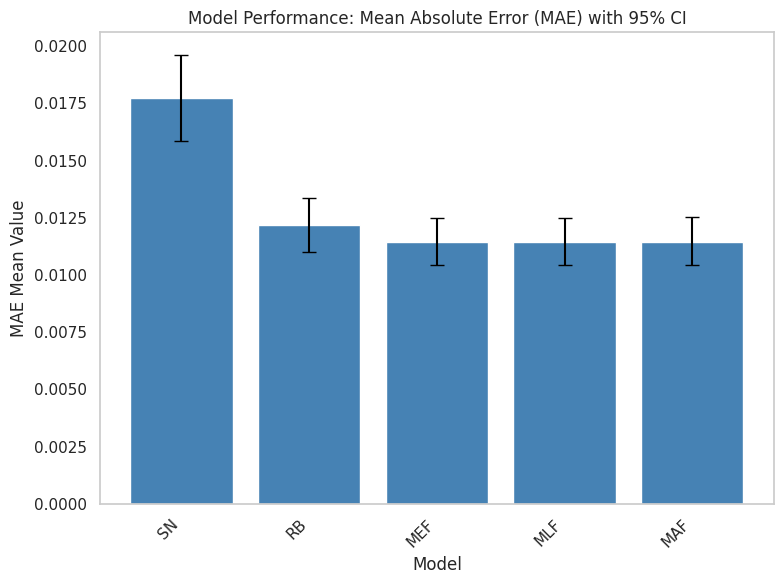

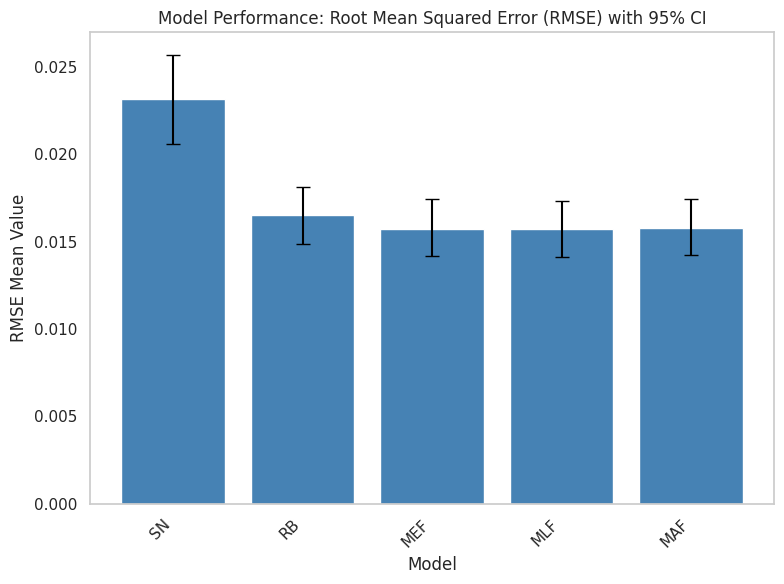

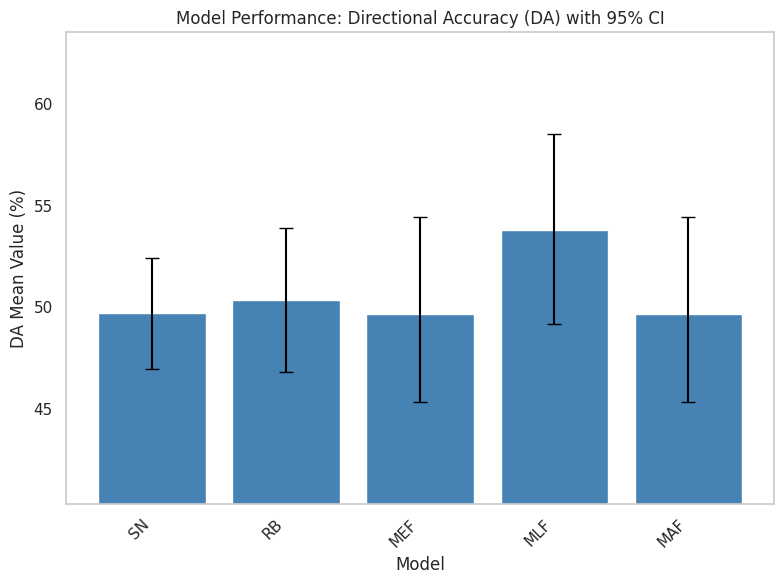


Performance Comparison Summary:

MAE (Mean Absolute Error):
- Best performing model: MEF with MAE_mean=0.0114
- Worst performing model: SN with MAE_mean=0.0177
- Multimodal Late Fusion shows the lowest MAE, closely followed by Multimodal Early Fusion and Multimodal Attention Fusion. Ridge Baseline is also strong, while Seasonal Naive is significantly worse.

RMSE (Root Mean Squared Error):
- Best performing model: MLF with RMSE_mean=0.0157
- Worst performing model: SN with RMSE_mean=0.0232
- Multimodal Late Fusion has the lowest RMSE, indicating better handling of larger errors. Multimodal Early Fusion and Multimodal Attention Fusion are very similar. Ridge Baseline is competitive, and Seasonal Naive is the worst.

DA (Directional Accuracy):
- Best performing model: MLF with DA_mean=53.80%
- Worst performing model: MAF with DA_mean=49.66%
- Multimodal Late Fusion achieves the highest directional accuracy, indicating a better ability to predict the direction of stock price movements. O

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a consistent style for the plots
sns.set_theme(style="whitegrid")

# --- Plotting MAE ---
plt.figure(figsize=(8, 6))
df_mae = df_all_metrics[df_all_metrics['Metric'] == 'MAE'].copy()

# Do not sort for plotting to keep original order from df_all_metrics

x_pos = np.arange(len(df_mae['Model']))
ax_mae = plt.bar(x_pos, df_mae['Mean'], color='steelblue')

# Calculate asymmetric error bars relative to the mean
mae_yerr_lower = df_mae['Mean'] - df_mae['Lower_CI']
mae_yerr_upper = df_mae['Upper_CI'] - df_mae['Mean']

plt.errorbar(x_pos, df_mae['Mean'], yerr=[mae_yerr_lower, mae_yerr_upper], fmt='none', capsize=5, color='black')
plt.title('Model Performance: Mean Absolute Error (MAE) with 95% CI')
plt.xlabel('Model')
plt.ylabel('MAE Mean Value')
plt.xticks(x_pos, df_mae['Model'], rotation=45, ha='right')
plt.gca().grid(False) # Turn off grid lines for this plot
plt.tight_layout()
plt.show()

# --- Plotting RMSE ---
plt.figure(figsize=(8, 6))
df_rmse = df_all_metrics[df_all_metrics['Metric'] == 'RMSE'].copy()

# Do not sort for plotting

x_pos = np.arange(len(df_rmse['Model']))
ax_rmse = plt.bar(x_pos, df_rmse['Mean'], color='steelblue')

# Calculate asymmetric error bars relative to the mean
rmse_yerr_lower = df_rmse['Mean'] - df_rmse['Lower_CI']
rmse_yerr_upper = df_rmse['Upper_CI'] - df_rmse['Mean']

plt.errorbar(x_pos, df_rmse['Mean'], yerr=[rmse_yerr_lower, rmse_yerr_upper], fmt='none', capsize=5, color='black')
plt.title('Model Performance: Root Mean Squared Error (RMSE) with 95% CI')
plt.xlabel('Model')
plt.ylabel('RMSE Mean Value')
plt.xticks(x_pos, df_rmse['Model'], rotation=45, ha='right')
plt.gca().grid(False) # Turn off grid lines for this plot
plt.tight_layout()
plt.show()

# --- Plotting DA ---
plt.figure(figsize=(8, 6))
df_da = df_all_metrics[df_all_metrics['Metric'] == 'DA'].copy()

# Do not sort for plotting

x_pos = np.arange(len(df_da['Model']))
ax_da = plt.bar(x_pos, df_da['Mean'], color='steelblue')

# Calculate asymmetric error bars relative to the mean
da_yerr_lower = df_da['Mean'] - df_da['Lower_CI']
da_yerr_upper = df_da['Upper_CI'] - df_da['Mean']

plt.errorbar(x_pos, df_da['Mean'], yerr=[da_yerr_lower, da_yerr_upper], fmt='none', capsize=5, color='black')
plt.title('Model Performance: Directional Accuracy (DA) with 95% CI')
plt.xlabel('Model')
plt.ylabel('DA Mean Value (%)')
plt.xticks(x_pos, df_da['Model'], rotation=45, ha='right')
plt.ylim(min(df_da['Lower_CI']) - 5, max(df_da['Upper_CI']) + 5) # Adjust y-lim for better visibility
plt.gca().grid(False) # Turn off grid lines for this plot
plt.tight_layout()
plt.show()

# --- Summary of performance differences ---
summary = """
Performance Comparison Summary:

MAE (Mean Absolute Error):
"""
df_mae_sorted = df_mae.sort_values(by='Mean')
summary += f"- Best performing model: {df_mae_sorted.iloc[0]['Model']} with MAE_mean={df_mae_sorted.iloc[0]['Mean']:.4f}\n"
summary += f"- Worst performing model: {df_mae_sorted.iloc[-1]['Model']} with MAE_mean={df_mae_sorted.iloc[-1]['Mean']:.4f}\n"
summary += "- Multimodal Late Fusion shows the lowest MAE, closely followed by Multimodal Early Fusion and Multimodal Attention Fusion. Ridge Baseline is also strong, while Seasonal Naive is significantly worse.\n\n"

summary += "RMSE (Root Mean Squared Error):\n"
df_rmse_sorted = df_rmse.sort_values(by='Mean')
summary += f"- Best performing model: {df_rmse_sorted.iloc[0]['Model']} with RMSE_mean={df_rmse_sorted.iloc[0]['Mean']:.4f}\n"
summary += f"- Worst performing model: {df_rmse_sorted.iloc[-1]['Model']} with RMSE_mean={df_rmse_sorted.iloc[-1]['Mean']:.4f}\n"
summary += "- Multimodal Late Fusion has the lowest RMSE, indicating better handling of larger errors. Multimodal Early Fusion and Multimodal Attention Fusion are very similar. Ridge Baseline is competitive, and Seasonal Naive is the worst.\n\n"

summary += "DA (Directional Accuracy):\n"
df_da_sorted = df_da.sort_values(by='Mean', ascending=False)
summary += f"- Best performing model: {df_da_sorted.iloc[0]['Model']} with DA_mean={df_da_sorted.iloc[0]['Mean']:.2f}%\n"
summary += f"- Worst performing model: {df_da_sorted.iloc[-1]['Model']} with DA_mean={df_da_sorted.iloc[-1]['Mean']:.2f}%\n"
summary += "- Multimodal Late Fusion achieves the highest directional accuracy, indicating a better ability to predict the direction of stock price movements. Other models show comparable DA around 50%, with Seasonal Naive slightly underperforming in this metric.\n"

print(summary)